In [1]:
from IPython.display import clear_output

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length,man_b):
        nn.Module.__init__(self)
#         num_hidden=50
        self.num_hidden=num_hidden
        self.l1 = nn.Linear(n_input-8 , num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        if man_b =='Learn':
            self.man_layer = nn.Linear(3, 1)
        elif man_b =='Init':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=True)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Nil':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.ones_like(self.man_layer.weight),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Exact':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        else:
            self.man_layer = nn.Linear(3, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
#         self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1=nn.Conv2d(2,2,kernel_size=3,stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0]=10000000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [ np.random.randint(4)  for x in range(int(env.n_layers))]
        self.hierarchy_actions[0]=4
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el = env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()

            pd = int(self.length / 2)
            mz = x.flatten()[:el ** 2].reshape(1, 1, el, el)

            aloc = x.flatten()[el ** 2:2 * el ** 2].reshape(1, 1, el, el)

            for r in range(int(self.n_layers - y)):
                mz = self.subsample(mz)
                aloc = self.subsample(aloc)
            # print(aloc)




            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')


            try:
                mz = F.pad(mz[:
                           , :, :, :], pad=(pd, pd, pd, pd),
                           value=1)

                aloc = F.pad(aloc[:
                             , :, :, :], pad=(pd, pd, pd, pd),
                             value=.00000001)

                pov = int(l / 2)
                _, _, xc, yc = torch.where(aloc == torch.max(aloc))
                # print(aloc)
                # print(xc,yc)
                xc = xc[0]  #
                yc = yc[0]
                mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
                aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

                aloc = torch.ceil(aloc - torch.min(aloc))
            except:
                print('nnn')
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el ** 2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el ** 2 + env.n_layers+1+5:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2 * el ** 2:2 * el ** 2 + env.n_layers+1].to(self.device))
        task = self.task_layer(x[:, 2 * el ** 2 + env.n_layers+1:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view**(env.n_layers-level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
#         if level != env.n_layers:
#             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
#         else:
#             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))
        eps=0.15
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss=states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards,states, next_states, dones, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason):
#     try:
        
#     print(ys)
#     print(ys!=env.n_layers)
#     print(type(reason))
    reason=reason[0]
    if ys.item()!=env.n_layers:
        if dones:
#             print('done')
            targets=rewards
        else:
        
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
#             print('done')
            targets = rewards
    #                 TS
        elif reason in [1,3]:
            
            targets = rewards
#             print("==============================")
#             print("level,reason,rewards,targets")
#             print(ys.item(),reason,rewards,targets)
#             print("==============================")

    #             TF
#         elif reason==3:
#     #                 man_state=env.get_super_manager_1(ns)[level-1]
#     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
#     #                 task=tasks[level-2]
#     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
#             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()
# #         + discount_factor * torch.stack([torch.max(y) for y in
# #                                                            [x[1][allowed_actions_current[x[0]]] for x in
# #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
# #             len(states), 1) * (1 - dones).float()

    
    # sl
        elif reason==2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_current[x[0]]] for x in
                                                            enumerate(Q.forward(states, ys, env))]]).reshape(
            len(states), 1) * (1 - dones).float()
# no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_next[x[0]]] for x in
                                                            enumerate(Q.forward(next_states, ys, env))]]).reshape(
            len(next_states), 1) * (1 - dones).float()

    
    
    
#     except:
#         print('aaa')
#     print("done,level,reason,rewards,targets")
#     print(dones,ys.item(),reason,rewards,targets)
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys,reason,allowed_actions_current = zip(*transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward,state, next_state, done, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()



def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    cl=[]
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64

    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        episode = i
        env.reset()
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 4.5:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 100):
                        print('Diverged1')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged2')
                        d = True

                    else:
                        d = False
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            moved_from_goal = False
            # env.current_level=2
            #             print('episode',episode)
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)

            #
            # print('loc',current_loc)
            # print('Task/Actions')
            # print(Q_policy.hierarchy_actions)

            current_level = copy.copy(Q_policy.current_level)
            #             print('level',current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                rf=env.manager_view**(env.n_layers-current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)
                # print(current_level,rf)
                # print(current_loc)
                # print(loc_idx2,locs)
            #                 loc_idx3 = [x for x in range(pos_man)rf if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            #             if current_level == 0:
            #                 a = 4
            #             else:
            #                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)

            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
                #                 print(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1])
                # a, eps = FlatQ.choose_action(env, level2, state_1, Q_policy.hierarchy_actions[level2 - 1], episode,
                #                              num_episodes)
            #             print(action)
            #             print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                    current_loc[1] / env.manager_view)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            #             print('NewState', ns)
            #             print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            #             print(step_counter)
            statef = env.get_super_manager_1(ns)[1]

            if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                # assert Q_policy.hierarchy_actions[level]!=4
                # if
                if Q_policy.hierarchy_actions[1] == 4:
                    #                     print('xxxxxx')
                    moved_from_goal = True

            if step_counter > 0:
                if Q_policy.current_level != 0:
                    #                     print('checking if level should change')
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy, moved_from_goal)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)
            #             print('Expected level', Q_policy.expected_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            # print(r)
            #             if current_level==2:
            #                 print(r)
            #             if moved_from_goal:
            #                 if r[-1] == -1:
            #                     break
            #                     print('hold up')

            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + env.n_layers + 1 + 5)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                # loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                #     ns[1] / env.manager_view)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)

            #             print(loc_idx2)
            #             print(int(env.maze.shape[0] ** 2) + loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason=x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current= env.possible_actions(level, state_1)
                
                #                 env.get_possible_actions(ns, level)

                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

                        #                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
                        #                                               Q_policy.hierarchy_actions[level - 1], d,
                        #                                               episode, num_episodes, discount_factor)
                        #
#                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
#                                               Q_policy.hierarchy_actions[level - 1], d,
#                                               episode, num_episodes, discount_factor, allowed_actions_next)
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level,reason,allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                statef = env.get_super_manager_1(current_loc)[level]
                                ns_1 = env.get_super_manager_1(Q_policy.loc)[level]
                                if statef != env.get_super_manager_1(env.goal_init_state)[level]:
                                    # assert Q_policy.hierarchy_actions[level]!=4
                                    # if
                                    if Q_policy.hierarchy_actions[level] == 4:
                                        print('x')
                                        break
                                #                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
                                #                                                       Q_policy.hierarchy_actions[level],
                                #                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
                                #                                                       discount_factor)
#                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
#                                                       Q_policy.hierarchy_actions[level],
#                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
#                                                       discount_factor, allowed_actions_next)

                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level != env.n_layers:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)

                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc ], env,
                                                                       level)

                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,reason,allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)
            # if moved_from_goal==True:
            #     print('Mpved from goal'
            #     )
            #     print(d)
            #     print(r)
            #     print(Q_policy.expected_level)
            #     print(Q_policy.current_level)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
                #                 print('diverged5000')
                break
            if d:
                cl.append(env.count_level_change)
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            # print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards,cl


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}


class FlatHierarchicalQ():
    def __init__(self, env):
        self.counter = 0
        self.Q_table = {}
        self.epsilon = 0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.layer_states[level] = ns ** 0.5
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0

    def update_Q_values(self, env, ns, state, level, reward, action, task, done, episode, num_episodes, discount_factor,
                        allowed_future_actions):

        alpha_0 = 0.5
        tau = 50
        #         if episode<num_episodes-500:
        #             episode_1=episode%100
        #         else:
        #             episode_1=episode
        div = num_episodes / 50
        alpha = 1 - (alpha_0 * tau) / (tau + (episode / div))
        self.alpha_new = 1 - alpha

        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
        #         allowed_future_actions=env.possible_actions(level,ns)
        if done:
            maxq = 0
        elif len(allowed_future_actions) != 1:
            maxq = np.max([self.Q_table[level][n_state1][task][a] for a in allowed_future_actions])
        else:
            assert 4 in allowed_future_actions
            maxq = np.max(self.Q_table[level][n_state1][task][4])
        current_q_value = self.Q_table[level][state1][task][action] + self.alpha_new * (
                    reward + discount_factor * maxq - self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value

    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

        #         if level == 2:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 2 / num_eps))
        #         else:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 4 / num_eps))

        eps = 0.1
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state = state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps




[3, 7]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


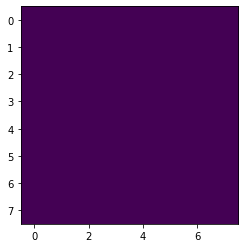

In [3]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,False,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

In [4]:
def print_policy(Q_policy, env, val_1, val_2):
    val_2=0
    val_1=0
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[y * el + j2] = a[1][0] * (el/env.manager_view*(env.n_layers-1)) + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    j2vv=[]
    value_list = {}
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
    #     this is used to find task
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
            j2vv.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
#             j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
            j2v.append([s,torch.max(vv.flatten()[:4], axis=0)[0].item()])
            j2vv.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append([s,torch.max(vv.flatten()[:4], axis=0)[0].item()])
            j2vv.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print(np.array(j2v).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
#     print([x for x in j2v])
    V = np.array(j2vv)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')
    return j2vv,j1v

In [10]:



# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 8000

batch_size = 1
discount_factor =1
learn_rate = 1e-5
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}
env1=copy.copy(env)

device = torch.device("cpu")

for man_init in ['Init']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
#             clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_3[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                               | 1/8000 [00:00<1:52:37,  1.18it/s]

epsilon 0.15


  1%|▍                                                                            | 51/8000 [02:08<10:58:43,  4.97s/it]

epsilon 0.15


  1%|▋                                                                             | 65/8000 [02:30<3:40:57,  1.67s/it]

x


  1%|▉                                                                           | 101/8000 [07:08<24:07:11, 10.99s/it]

epsilon 0.15


  2%|█▎                                                                          | 134/8000 [11:01<18:09:27,  8.31s/it]

x


  2%|█▍                                                                           | 151/8000 [12:10<6:07:07,  2.81s/it]

epsilon 0.15


  2%|█▋                                                                           | 181/8000 [13:49<9:13:49,  4.25s/it]

x


  3%|█▉                                                                           | 201/8000 [14:35<4:12:09,  1.94s/it]

epsilon 0.15


  3%|██▍                                                                          | 251/8000 [16:33<2:43:17,  1.26s/it]

epsilon 0.15


  4%|██▉                                                                          | 301/8000 [17:51<1:05:47,  1.95it/s]

epsilon 0.15


  4%|██▉                                                                          | 306/8000 [17:58<3:16:43,  1.53s/it]

x


  4%|███▍                                                                         | 351/8000 [18:23<1:09:26,  1.84it/s]

epsilon 0.15
[201.56666666666666]
min mean 201.56666666666666
last mean 350    201.566667
dtype: float64


  5%|███▊                                                                         | 401/8000 [19:04<1:50:16,  1.15it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332]
min mean 150.76333333333332
last mean 400    150.763333
dtype: float64


  5%|███▊                                                                         | 402/8000 [19:08<3:49:29,  1.81s/it]

x


  6%|████▎                                                                        | 451/8000 [19:56<1:45:56,  1.19it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667]
min mean 102.51666666666667
last mean 450    102.516667
dtype: float64


  6%|████▊                                                                        | 501/8000 [20:30<1:20:35,  1.55it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49]
min mean 80.49
last mean 500    80.736667
dtype: float64


  7%|█████▎                                                                       | 551/8000 [21:05<2:35:17,  1.25s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93]
min mean 60.93
last mean 550    61.256667
dtype: float64


  7%|█████▊                                                                         | 593/8000 [21:39<55:22,  2.23it/s]

x


  8%|█████▊                                                                       | 601/8000 [21:44<1:13:46,  1.67it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07]
min mean 50.07
last mean 600    50.666667
dtype: float64


  8%|██████▎                                                                      | 651/8000 [22:38<1:13:27,  1.67it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333]
min mean 48.75333333333333
last mean 650    54.086667
dtype: float64


  9%|██████▊                                                                      | 702/8000 [23:29<1:43:25,  1.18it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 700    55.36
dtype: float64


  9%|███████▏                                                                     | 752/8000 [24:16<1:21:19,  1.49it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 750    51.143333
dtype: float64


 10%|███████▋                                                                     | 801/8000 [25:25<3:49:24,  1.91s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 800    54.47
dtype: float64


 11%|████████▏                                                                    | 851/8000 [28:43<7:28:05,  3.76s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 850    72.503333
dtype: float64


 11%|████████▋                                                                    | 901/8000 [32:40<5:30:32,  2.79s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 900    98.576667
dtype: float64


 11%|████████▋                                                                    | 906/8000 [32:55<7:20:26,  3.73s/it]

x


 12%|█████████                                                                   | 951/8000 [35:32<11:02:41,  5.64s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 950    115.9
dtype: float64


 13%|█████████▌                                                                  | 1001/8000 [36:40<1:35:01,  1.23it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1000    120.736667
dtype: float64


 13%|█████████▉                                                                  | 1051/8000 [37:15<1:48:12,  1.07it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1050    120.716667
dtype: float64
x


 14%|██████████▍                                                                 | 1101/8000 [38:04<2:05:05,  1.09s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1100    120.37
dtype: float64


 14%|███████████▏                                                                  | 1152/8000 [38:50<46:51,  2.44it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1150    104.873333
dtype: float64


 15%|███████████▍                                                                | 1201/8000 [39:23<3:13:42,  1.71s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1200    79.21
dtype: float64


 16%|███████████▉                                                                | 1251/8000 [40:03<1:02:05,  1.81it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1250    60.043333
dtype: float64


 16%|████████████▎                                                               | 1301/8000 [40:27<1:00:28,  1.85it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333]
min mean 48.75333333333333
last mean 1300    49.91
dtype: float64


 17%|█████████████▏                                                                | 1350/8000 [40:46<38:27,  2.88it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667]
min mean 46.25666666666667
last mean 1350    46.256667
dtype: float64


 18%|█████████████▋                                                                | 1402/8000 [41:00<29:18,  3.75it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334]
min mean 38.483333333333334
last mean 1400    38.483333
dtype: float64


 18%|██████████████▏                                                               | 1451/8000 [41:20<32:45,  3.33it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667]
min mean 32.68666666666667
last mean 1450    32.69
dtype: float64


 19%|██████████████▎                                                             | 1500/8000 [41:40<1:34:41,  1.14it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666]
min mean 29.496666666666666
last mean 1500    29.496667
dtype: float64


 19%|███████████████▏                                                              | 1552/8000 [41:58<29:15,  3.67it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333]
min mean 24.043333333333333
last mean 1550    24.163333
dtype: float64


 20%|███████████████▌                                                              | 1601/8000 [42:22<59:08,  1.80it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333]
min mean 23.133333333333333
last mean 1600    23.62
dtype: float64


 21%|███████████████▋                                                            | 1650/8000 [42:41<1:04:00,  1.65it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666]
min mean 22.836666666666666
last mean 1650    23.2
dtype: float64


 21%|████████████████▌                                                             | 1701/8000 [42:58<38:07,  2.75it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1700    23.85
dtype: float64


 22%|████████████████▋                                                           | 1751/8000 [45:25<4:19:45,  2.49s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1750    51.58
dtype: float64


 23%|█████████████████▌                                                            | 1801/8000 [45:52<13:04,  7.90it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1800    52.636667
dtype: float64


 23%|██████████████████                                                            | 1851/8000 [46:04<26:32,  3.86it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1850    50.68
dtype: float64


 24%|██████████████████▌                                                           | 1902/8000 [46:17<16:41,  6.09it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1900    47.563333
dtype: float64


 24%|███████████████████                                                           | 1950/8000 [46:29<36:52,  2.73it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 1950    45.483333
dtype: float64


 25%|███████████████████▌                                                          | 2001/8000 [46:40<28:17,  3.53it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666]
min mean 22.836666666666666
last mean 2000    43.586667
dtype: float64


 26%|████████████████████                                                          | 2052/8000 [46:55<20:40,  4.79it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334]
min mean 13.403333333333334
last mean 2050    13.403333
dtype: float64


 26%|████████████████████▌                                                         | 2103/8000 [47:02<13:57,  7.04it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667]
min mean 9.146666666666667
last mean 2100    9.236667
dtype: float64


 27%|████████████████████▉                                                         | 2152/8000 [47:10<14:14,  6.84it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333]
min mean 8.733333333333333
last mean 2150    8.733333
dtype: float64


 28%|█████████████████████▍                                                        | 2202/8000 [47:18<19:07,  5.05it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13]
min mean 8.13
last mean 2200    8.216667
dtype: float64


 28%|█████████████████████▉                                                        | 2251/8000 [47:26<14:27,  6.63it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667]
min mean 7.836666666666667
last mean 2250    7.85
dtype: float64


 29%|██████████████████████▍                                                       | 2301/8000 [47:34<14:20,  6.63it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333]
min mean 7.423333333333333
last mean 2300    7.423333
dtype: float64


 29%|██████████████████████▉                                                       | 2351/8000 [47:41<15:28,  6.09it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667]
min mean 6.716666666666667
last mean 2350    6.723333
dtype: float64


 30%|███████████████████████▍                                                      | 2402/8000 [47:48<12:41,  7.36it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334]
min mean 6.683333333333334
last mean 2400    6.69
dtype: float64


 30%|███████████████████████▍                                                      | 2405/8000 [47:49<17:21,  5.37it/s]

x


 30%|███████████████████████▌                                                      | 2420/8000 [47:51<13:40,  6.80it/s]

x


 31%|███████████████████████▉                                                      | 2451/8000 [47:57<17:09,  5.39it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62]
min mean 6.62
last mean 2450    6.72
dtype: float64


 31%|████████████████████████▍                                                     | 2501/8000 [48:04<10:55,  8.39it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58]
min mean 6.58
last mean 2500    6.603333
dtype: float64


 31%|████████████████████████▌                                                     | 2513/8000 [48:06<13:23,  6.83it/s]

x


 32%|████████████████████████▉                                                     | 2552/8000 [48:12<15:57,  5.69it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333]
min mean 6.423333333333333
last mean 2550    6.566667
dtype: float64


 33%|█████████████████████████▎                                                    | 2601/8000 [48:19<13:14,  6.80it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333]
min mean 6.423333333333333
last mean 2600    6.456667
dtype: float64


 33%|█████████████████████████▊                                                    | 2652/8000 [48:27<17:14,  5.17it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333]
min mean 6.423333333333333
last mean 2650    6.486667
dtype: float64


 34%|██████████████████████████▎                                                   | 2701/8000 [48:34<10:47,  8.18it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333]
min mean 6.423333333333333
last mean 2700    6.46
dtype: float64


 34%|██████████████████████████▊                                                   | 2751/8000 [48:42<13:05,  6.68it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38]
min mean 6.38
last mean 2750    6.38
dtype: float64


 35%|███████████████████████████▎                                                  | 2801/8000 [48:50<14:05,  6.15it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334]
min mean 6.343333333333334
last mean 2800    6.49
dtype: float64


 36%|███████████████████████████▊                                                  | 2852/8000 [48:59<11:36,  7.40it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334]
min mean 6.343333333333334
last mean 2850    6.676667
dtype: float64


 36%|████████████████████████████▎                                                 | 2901/8000 [49:06<12:31,  6.79it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334]
min mean 6.343333333333334
last mean 2900    6.86
dtype: float64


 37%|████████████████████████████▊                                                 | 2953/8000 [49:14<10:34,  7.95it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334]
min mean 6.343333333333334
last mean 2950    6.8066

 38%|█████████████████████████████▎                                                | 3001/8000 [49:22<17:25,  4.78it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334]
min mean 6.343333333333334
last 

 38%|█████████████████████████████▊                                                | 3052/8000 [49:29<11:29,  7.18it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334]
min mean 6.34

 39%|██████████████████████████████▏                                               | 3102/8000 [49:37<11:47,  6.92it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 39%|██████████████████████████████▋                                               | 3152/8000 [49:44<09:59,  8.09it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 40%|███████████████████████████████▏                                              | 3201/8000 [49:51<13:28,  5.94it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 41%|███████████████████████████████▋                                              | 3251/8000 [49:57<11:45,  6.73it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 41%|████████████████████████████████▏                                             | 3301/8000 [50:18<54:37,  1.43it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 42%|████████████████████████████████▋                                             | 3351/8000 [50:38<57:38,  1.34it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 43%|█████████████████████████████████▏                                            | 3402/8000 [51:16<27:30,  2.79it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 43%|█████████████████████████████████▋                                            | 3452/8000 [51:34<18:59,  3.99it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 44%|█████████████████████████████████▎                                          | 3501/8000 [51:51<1:11:17,  1.05it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 44%|██████████████████████████████████▌                                           | 3551/8000 [52:02<14:04,  5.27it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 45%|███████████████████████████████████                                           | 3601/8000 [52:24<12:40,  5.79it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 46%|███████████████████████████████████▌                                          | 3651/8000 [52:52<42:53,  1.69it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 46%|████████████████████████████████████                                          | 3702/8000 [53:10<20:05,  3.57it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 47%|████████████████████████████████████▌                                         | 3751/8000 [53:29<19:39,  3.60it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 48%|█████████████████████████████████████                                         | 3801/8000 [53:48<21:34,  3.24it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 48%|█████████████████████████████████████▌                                        | 3851/8000 [53:57<11:41,  5.91it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 49%|██████████████████████████████████████                                        | 3901/8000 [54:06<11:26,  5.97it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 49%|██████████████████████████████████████▌                                       | 3951/8000 [54:15<18:09,  3.72it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 50%|███████████████████████████████████████                                       | 4001/8000 [54:26<22:30,  2.96it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 51%|███████████████████████████████████████▍                                      | 4051/8000 [54:37<12:02,  5.47it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 51%|███████████████████████████████████████▉                                      | 4101/8000 [54:49<41:42,  1.56it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 52%|████████████████████████████████████████▍                                     | 4151/8000 [55:10<28:43,  2.23it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 53%|████████████████████████████████████████▉                                     | 4201/8000 [55:23<15:22,  4.12it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 53%|████████████████████████████████████████▍                                   | 4251/8000 [55:41<1:06:43,  1.07s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 54%|█████████████████████████████████████████▉                                    | 4301/8000 [56:14<31:46,  1.94it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 54%|██████████████████████████████████████████▍                                   | 4351/8000 [56:28<11:44,  5.18it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 55%|██████████████████████████████████████████▋                                   | 4383/8000 [56:37<14:42,  4.10it/s]

x


 55%|██████████████████████████████████████████▉                                   | 4402/8000 [56:44<17:49,  3.36it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 56%|███████████████████████████████████████████▍                                  | 4451/8000 [57:01<33:27,  1.77it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 56%|███████████████████████████████████████████▉                                  | 4501/8000 [57:27<20:26,  2.85it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 57%|████████████████████████████████████████████▎                                 | 4551/8000 [57:52<24:22,  2.36it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 58%|████████████████████████████████████████████▊                                 | 4601/8000 [58:10<25:13,  2.25it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 58%|█████████████████████████████████████████████▎                                | 4651/8000 [58:32<15:05,  3.70it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 59%|█████████████████████████████████████████████▊                                | 4701/8000 [58:45<17:10,  3.20it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 59%|██████████████████████████████████████████████▎                               | 4751/8000 [59:05<29:17,  1.85it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 60%|██████████████████████████████████████████████▊                               | 4801/8000 [59:25<13:16,  4.01it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 61%|███████████████████████████████████████████████▎                              | 4851/8000 [59:40<16:42,  3.14it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 61%|███████████████████████████████████████████████▊                              | 4901/8000 [59:51<11:24,  4.53it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 62%|███████████████████████████████████████████████                             | 4951/8000 [1:00:05<09:32,  5.32it/s]

x
epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333

 63%|███████████████████████████████████████████████▌                            | 5002/8000 [1:00:16<08:08,  6.14it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 63%|███████████████████████████████████████████████▉                            | 5051/8000 [1:00:28<13:37,  3.61it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 64%|███████████████████████████████████████████████▏                          | 5101/8000 [1:00:54<1:12:21,  1.50s/it]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 64%|████████████████████████████████████████████████▉                           | 5151/8000 [1:01:06<10:47,  4.40it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 65%|█████████████████████████████████████████████████▍                          | 5201/8000 [1:01:18<12:12,  3.82it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 66%|█████████████████████████████████████████████████▉                          | 5251/8000 [1:01:29<13:54,  3.29it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 66%|██████████████████████████████████████████████████▎                         | 5301/8000 [1:01:39<10:39,  4.22it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 67%|██████████████████████████████████████████████████▊                         | 5351/8000 [1:01:50<09:56,  4.44it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 68%|███████████████████████████████████████████████████▎                        | 5401/8000 [1:02:00<10:22,  4.17it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 68%|███████████████████████████████████████████████████▊                        | 5451/8000 [1:02:12<08:49,  4.81it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 68%|███████████████████████████████████████████████████▊                        | 5452/8000 [1:02:12<13:25,  3.16it/s]

x


 69%|████████████████████████████████████████████████████▎                       | 5501/8000 [1:02:24<12:29,  3.33it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 69%|████████████████████████████████████████████████████▍                       | 5524/8000 [1:02:30<10:29,  3.93it/s]

x


 69%|████████████████████████████████████████████████████▋                       | 5551/8000 [1:02:36<08:39,  4.71it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 70%|█████████████████████████████████████████████████████▏                      | 5601/8000 [1:02:48<12:27,  3.21it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 71%|█████████████████████████████████████████████████████▋                      | 5651/8000 [1:02:58<09:53,  3.96it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 71%|██████████████████████████████████████████████████████▏                     | 5701/8000 [1:03:09<10:43,  3.57it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 72%|██████████████████████████████████████████████████████▋                     | 5751/8000 [1:03:21<10:12,  3.67it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 73%|███████████████████████████████████████████████████████                     | 5801/8000 [1:03:33<11:22,  3.22it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 73%|███████████████████████████████████████████████████████▌                    | 5852/8000 [1:03:45<06:19,  5.66it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 74%|████████████████████████████████████████████████████████                    | 5901/8000 [1:03:57<08:35,  4.07it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 74%|████████████████████████████████████████████████████████▏                   | 5908/8000 [1:03:59<06:29,  5.37it/s]

x


 74%|████████████████████████████████████████████████████████▌                   | 5951/8000 [1:04:09<08:16,  4.13it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 75%|█████████████████████████████████████████████████████████                   | 6001/8000 [1:04:18<04:48,  6.93it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 76%|█████████████████████████████████████████████████████████▍                  | 6051/8000 [1:04:27<06:58,  4.65it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 76%|█████████████████████████████████████████████████████████▉                  | 6102/8000 [1:04:35<05:07,  6.18it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 77%|██████████████████████████████████████████████████████████▍                 | 6151/8000 [1:04:45<06:45,  4.56it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 78%|██████████████████████████████████████████████████████████▉                 | 6201/8000 [1:04:56<06:09,  4.87it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 78%|███████████████████████████████████████████████████████████▍                | 6251/8000 [1:05:05<05:47,  5.04it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 79%|███████████████████████████████████████████████████████████▊                | 6301/8000 [1:05:14<04:35,  6.16it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 79%|████████████████████████████████████████████████████████████▎               | 6351/8000 [1:05:23<05:27,  5.04it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 79%|████████████████████████████████████████████████████████████▍               | 6358/8000 [1:05:25<05:03,  5.40it/s]

x


 80%|████████████████████████████████████████████████████████████▊               | 6401/8000 [1:05:33<06:13,  4.28it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 81%|█████████████████████████████████████████████████████████████▎              | 6451/8000 [1:05:42<04:50,  5.33it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 81%|█████████████████████████████████████████████████████████████▊              | 6501/8000 [1:05:51<06:25,  3.89it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 82%|██████████████████████████████████████████████████████████████▏             | 6551/8000 [1:06:00<05:27,  4.42it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 83%|██████████████████████████████████████████████████████████████▋             | 6601/8000 [1:06:10<04:20,  5.38it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 83%|███████████████████████████████████████████████████████████████▏            | 6651/8000 [1:06:20<05:32,  4.06it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 84%|███████████████████████████████████████████████████████████████▋            | 6701/8000 [1:06:30<05:54,  3.67it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 84%|████████████████████████████████████████████████████████████████▏           | 6752/8000 [1:06:40<03:21,  6.20it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 85%|████████████████████████████████████████████████████████████████▌           | 6802/8000 [1:06:49<03:25,  5.84it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 86%|█████████████████████████████████████████████████████████████████           | 6851/8000 [1:07:00<03:45,  5.10it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 86%|█████████████████████████████████████████████████████████████████▍          | 6890/8000 [1:07:08<03:21,  5.51it/s]

x


 86%|█████████████████████████████████████████████████████████████████▌          | 6901/8000 [1:07:10<03:08,  5.82it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 87%|██████████████████████████████████████████████████████████████████          | 6951/8000 [1:07:20<04:01,  4.34it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 88%|██████████████████████████████████████████████████████████████████▌         | 7001/8000 [1:07:30<04:09,  4.01it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 88%|██████████████████████████████████████████████████████████████████▉         | 7051/8000 [1:07:40<02:58,  5.31it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 89%|███████████████████████████████████████████████████████████████████▍        | 7102/8000 [1:07:50<02:28,  6.04it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 89%|███████████████████████████████████████████████████████████████████▉        | 7151/8000 [1:07:59<02:45,  5.13it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 90%|████████████████████████████████████████████████████████████████████▍       | 7201/8000 [1:08:09<02:54,  4.59it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 91%|████████████████████████████████████████████████████████████████████▉       | 7251/8000 [1:08:20<02:57,  4.23it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 91%|█████████████████████████████████████████████████████████████████████▎      | 7301/8000 [1:08:30<02:13,  5.23it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 91%|█████████████████████████████████████████████████████████████████████▍      | 7315/8000 [1:08:33<02:24,  4.73it/s]

x


 92%|█████████████████████████████████████████████████████████████████████▊      | 7351/8000 [1:08:41<02:11,  4.92it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 92%|██████████████████████████████████████████████████████████████████████      | 7376/8000 [1:08:46<01:48,  5.77it/s]

x


 93%|██████████████████████████████████████████████████████████████████████▎     | 7401/8000 [1:08:51<01:45,  5.69it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 93%|██████████████████████████████████████████████████████████████████████▊     | 7451/8000 [1:09:00<01:53,  4.85it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 94%|███████████████████████████████████████████████████████████████████████▎    | 7501/8000 [1:09:11<02:08,  3.89it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 94%|███████████████████████████████████████████████████████████████████████▋    | 7551/8000 [1:09:21<01:25,  5.24it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 95%|████████████████████████████████████████████████████████████████████████▏   | 7602/8000 [1:09:32<01:21,  4.87it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 96%|████████████████████████████████████████████████████████████████████████▋   | 7651/8000 [1:09:43<01:22,  4.24it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 96%|█████████████████████████████████████████████████████████████████████████▏  | 7701/8000 [1:09:54<01:06,  4.48it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 97%|█████████████████████████████████████████████████████████████████████████▋  | 7751/8000 [1:10:05<01:10,  3.56it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 98%|██████████████████████████████████████████████████████████████████████████  | 7801/8000 [1:10:16<00:39,  5.00it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 98%|██████████████████████████████████████████████████████████████████████████▌ | 7851/8000 [1:10:27<00:32,  4.56it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 99%|███████████████████████████████████████████████████████████████████████████ | 7901/8000 [1:10:37<00:22,  4.38it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

 99%|███████████████████████████████████████████████████████████████████████████▌| 7951/8000 [1:10:48<00:11,  4.42it/s]

epsilon 0.15
[201.56666666666666, 150.76333333333332, 102.51666666666667, 80.49, 60.93, 50.07, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 48.75333333333333, 46.25666666666667, 38.483333333333334, 32.68666666666667, 29.496666666666666, 24.043333333333333, 23.133333333333333, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 22.836666666666666, 13.403333333333334, 9.146666666666667, 8.733333333333333, 8.13, 7.836666666666667, 7.423333333333333, 6.716666666666667, 6.683333333333334, 6.62, 6.58, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.423333333333333, 6.38, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.343333333333334, 6.34333333333

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [1:10:59<00:00,  1.88it/s]


Maybe store policy intermittently, one possible reason for edges having worse Q is because of search, how does epsilon affect it, also failing,closer to task fail less , Q values with correct manager policy? print reward per action state 

[['S' 'S' 'S' 'S']
 ['E' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['N' 'E' 'N' 'W']]
[[list([(0, -9.247806549072266), (1, -8.613910675048828), (2, -8.633719444274902), (3, -9.419559478759766)])
  list([(0, -9.157308578491211), (1, -8.31016731262207), (2, -8.615643501281738), (3, -8.587505340576172)])
  list([(0, -8.413891792297363), (1, -6.995148658752441), (2, -8.20012092590332), (3, -7.4373321533203125)])
  list([(0, -8.588695526123047), (1, -7.16569709777832), (2, -8.497732162475586), (3, -7.170595169067383)])]
 [list([(0, -8.89952564239502), (1, -8.625945091247559), (2, -8.492546081542969), (3, -9.61961841583252)])
  list([(0, -8.352893829345703), (1, -7.959192276000977), (2, -7.965157508850098), (3, -8.217421531677246)])
  list([(0, -6.862192630767822), (1, -6.140421390533447), (2, -7.332737445831299), (3, -6.559682846069336)])
  list([(0, -7.482298374176025), (1, -6.738997459411621), (2, -7.973871231079102), (3, -6.582038402557373)])]
 [list([(0, -7.203760623931885), (1, -7.93589878

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


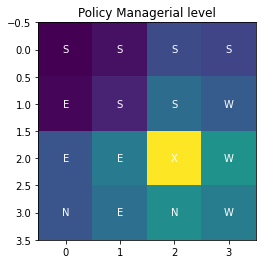

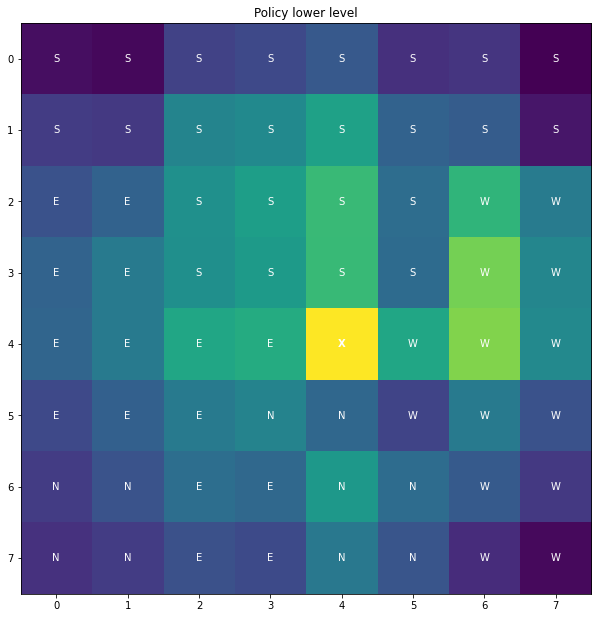

cccc


In [11]:
v2,v1=print_policy(Q_policy, env1, 0, 0)

In [12]:
np.array([int(x*10)/10 for x in v1]).reshape(4,4)

array([[-8.6, -8.3, -6.9, -7.1],
       [-8.4, -7.9, -6.1, -6.5],
       [-6.7, -5.7, -1.6, -5. ],
       [-6.7, -6. , -5.2, -5.6]])

In [15]:
np.array([int(x*10)/10 for x in v2]).reshape(8,8)

array([[-4.9, -5.1, -3.4, -3.2, -2.7, -3.9, -3.8, -5.3],
       [-3.6, -3.7, -1.6, -1.4, -0.9, -2.5, -2.6, -4.7],
       [-3. , -2.5, -1.3, -1. , -0.5, -2.2, -0.6, -1.8],
       [-2.5, -1.8, -1.3, -1.1, -0.5, -2.2, -0.2, -1.5],
       [-2.4, -1.8, -0.8, -0.7,  0. , -0.8, -0.1, -1.4],
       [-3.2, -2.5, -1.8, -1.6, -2.3, -3.3, -1.8, -3. ],
       [-3.6, -2.9, -2.1, -2.3, -1.1, -2.2, -2.7, -3.7],
       [-3.9, -3.6, -3. , -3.2, -1.9, -2.9, -4.1, -5. ]])

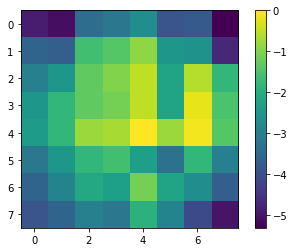

In [13]:
plt.imshow(np.array([int(x*10)/10 for x in v2]).reshape(8,8))
plt.colorbar()

In [14]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[0.9858, 2.1190, 4.0255]], requires_grad=True)

In [30]:
j22v=[[0, -8.379714012145996], [1, -7.813291549682617], [2, -5.757637977600098], [3, -4.8658766746521], [4, -4.666060447692871], [5, -5.652614593505859], [6, -5.788243293762207], [7, -6.734281539916992], [8, -7.682886123657227], [9, -7.158623695373535], [10, -4.243691444396973], [11, -3.472789764404297], [12, -3.0390586853027344], [13, -4.4140424728393555], [14, -4.5271525382995605], [15, -6.326658248901367], [16, -5.10914421081543], [17, -4.468596935272217], [18, -3.478076934814453], [19, -2.027137517929077], [20, -1.8097412586212158], [21, -3.447410821914673], [22, -4.1411285400390625], [23, -5.794959545135498], [24, -3.9847092628479004], [25, -3.251249313354492], [26, -3.302381992340088], [27, -2.118105888366699], [28, -1.4816503524780273], [29, -2.6978094577789307], [30, -4.607236862182617], [31, -5.360954761505127], [32, -3.741476535797119], [33, -2.8469419479370117], [34, -1.9483336210250854], [35, -1.5916650295257568], 0, [37, -0.8918489813804626], [38, -1.7490123510360718], [39, -2.7695250511169434], [40, -4.977910041809082], [41, -4.297420978546143], [42, -3.5353939533233643], [43, -2.7225754261016846], [44, -1.1971434354782104], [45, -1.9122778177261353], [46, -3.072326183319092], [47, -3.949472665786743], [48, -5.321995735168457], [49, -4.8079962730407715], [50, -4.539423942565918], [51, -4.572300910949707], [52, -1.917624831199646], [53, -2.922158718109131], [54, -3.8453571796417236], [55, -4.629354953765869], [56, -6.374579429626465], [57, -6.352219104766846], [58, -5.706751823425293], [59, -5.3661322593688965], [60, -2.100585699081421], [61, -3.493546962738037], [62, -4.95258903503418], [63, -5.897077560424805]]

In [33]:
[np.array(x)[-1] for x in j22v]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

  0%|                                                                              | 1/5000 [00:08<11:09:31,  8.04s/it]

epsilon 0.7637866666666667


  1%|▊                                                                               | 51/5000 [01:10<53:08,  1.55it/s]

epsilon 0.7365


  2%|█▌                                                                           | 101/5000 [02:05<1:00:31,  1.35it/s]

epsilon 0.723


  3%|██                                                                             | 127/5000 [02:28<34:03,  2.38it/s]

x


  3%|██▎                                                                          | 151/5000 [02:52<1:23:35,  1.03s/it]

epsilon 0.7095


  4%|███                                                                          | 201/5000 [03:35<1:01:19,  1.30it/s]

epsilon 0.696


  5%|███▊                                                                         | 251/5000 [04:01<1:15:40,  1.05it/s]

epsilon 0.6825


  6%|████▊                                                                          | 303/5000 [04:25<15:35,  5.02it/s]

epsilon 0.669


  7%|█████▏                                                                         | 327/5000 [04:34<29:19,  2.66it/s]

x


  7%|█████▌                                                                         | 351/5000 [04:41<41:28,  1.87it/s]

epsilon 0.6555
[56.31]
min mean 56.31
last mean 350    56.73
dtype: float64


  7%|█████▊                                                                         | 369/5000 [04:48<29:02,  2.66it/s]

x


  8%|██████▎                                                                        | 401/5000 [05:02<36:55,  2.08it/s]

epsilon 0.642
[56.31, 48.18666666666667]
min mean 48.18666666666667
last mean 400    48.186667
dtype: float64


  8%|██████▍                                                                        | 408/5000 [05:05<38:40,  1.98it/s]

x


  9%|███████▏                                                                       | 451/5000 [05:17<25:15,  3.00it/s]

epsilon 0.6285000000000001
[56.31, 48.18666666666667, 40.11]
min mean 40.11
last mean 450    40.11
dtype: float64


 10%|███████▋                                                                       | 486/5000 [05:27<21:49,  3.45it/s]

x


 10%|███████▉                                                                       | 501/5000 [05:32<23:27,  3.20it/s]

epsilon 0.615
[56.31, 48.18666666666667, 40.11, 31.723333333333333]
min mean 31.723333333333333
last mean 500    31.723333
dtype: float64


 11%|████████▋                                                                      | 551/5000 [05:46<20:05,  3.69it/s]

epsilon 0.6014999999999999
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18]
min mean 28.18
last mean 550    28.18
dtype: float64


 12%|█████████▍                                                                     | 600/5000 [05:59<17:37,  4.16it/s]

epsilon 0.588
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78]
min mean 24.78
last mean 600    24.783333
dtype: float64


 13%|██████████▎                                                                    | 651/5000 [06:11<13:23,  5.41it/s]

epsilon 0.5745
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14]
min mean 23.14
last mean 650    23.14
dtype: float64


 14%|██████████▊                                                                    | 682/5000 [06:19<20:04,  3.58it/s]

x


 14%|███████████                                                                    | 702/5000 [06:24<13:34,  5.27it/s]

epsilon 0.5609999999999999
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93]
min mean 20.93
last mean 700    20.93
dtype: float64


 15%|███████████▊                                                                   | 751/5000 [06:36<22:36,  3.13it/s]

epsilon 0.5475
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335]
min mean 20.053333333333335
last mean 750    20.2
dtype: float64


 16%|████████████▎                                                                  | 776/5000 [06:41<14:31,  4.85it/s]

x


 16%|████████████▋                                                                  | 800/5000 [06:47<11:14,  6.23it/s]

epsilon 0.534
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32]
min mean 19.32
last mean 800    19.32
dtype: float64


 17%|█████████████▍                                                                 | 850/5000 [06:57<09:38,  7.17it/s]

epsilon 0.5205
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333]
min mean 18.273333333333333
last mean 850    18.273333
dtype: float64


 18%|██████████████▏                                                                | 900/5000 [07:05<12:53,  5.30it/s]

epsilon 0.507
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12]
min mean 17.12
last mean 900    17.16
dtype: float64


 19%|███████████████                                                                | 951/5000 [07:15<19:11,  3.52it/s]

epsilon 0.4935
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71]
min mean 16.71
last mean 950    16.833333
dtype: float64


 20%|███████████████▌                                                              | 1001/5000 [07:23<15:59,  4.17it/s]

epsilon 0.48
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667]
min mean 15.466666666666667
last mean 1000    15.593333
dtype: float64


 21%|████████████████▍                                                             | 1052/5000 [07:32<12:49,  5.13it/s]

epsilon 0.4665
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27]
min mean 14.27
last mean 1050    14.27
dtype: float64


 22%|█████████████████▏                                                            | 1098/5000 [07:40<11:43,  5.55it/s]

x


 22%|█████████████████▏                                                            | 1101/5000 [07:41<14:46,  4.40it/s]

epsilon 0.45299999999999996
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666]
min mean 13.506666666666666
last mean 1100    13.713333
dtype: float64


 23%|█████████████████▉                                                            | 1151/5000 [07:51<16:54,  3.79it/s]

epsilon 0.4395
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667]
min mean 13.476666666666667
last mean 1150    13.78
dtype: float64


 24%|██████████████████▊                                                           | 1202/5000 [08:01<15:14,  4.15it/s]

epsilon 0.426
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667]
min mean 13.476666666666667
last mean 1200    13.803333
dtype: float64


 25%|███████████████████▌                                                          | 1252/5000 [08:09<08:00,  7.80it/s]

epsilon 0.4125
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667]
min mean 13.206666666666667
last mean 1250    13.206667
dtype: float64


 26%|████████████████████▎                                                         | 1302/5000 [08:17<08:16,  7.44it/s]

epsilon 0.39899999999999997
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334]
min mean 12.933333333333334
last mean 1300    12.94
dtype: float64


 26%|████████████████████▋                                                         | 1323/5000 [08:22<21:17,  2.88it/s]

x


 27%|█████████████████████                                                         | 1352/5000 [08:26<06:55,  8.79it/s]

epsilon 0.3855
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333]
min mean 12.853333333333333
last mean 1350    13.226667
dtype: float64


 28%|█████████████████████▊                                                        | 1402/5000 [08:34<10:35,  5.66it/s]

epsilon 0.372
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334]
min mean 12.843333333333334
last mean 1400    12.903333
dtype: float64


 29%|██████████████████████▋                                                       | 1453/5000 [08:43<09:40,  6.11it/s]

epsilon 0.3585
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334]
min mean 12.403333333333334
last mean 1450    12.436667
dtype: float64


 30%|███████████████████████▍                                                      | 1501/5000 [08:50<11:25,  5.10it/s]

epsilon 0.345
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334]
min mean 12.073333333333334
last mean 1500    12.083333
dtype: float64


 31%|████████████████████████                                                      | 1539/5000 [08:56<07:05,  8.14it/s]

x


 31%|████████████████████████▏                                                     | 1552/5000 [08:58<07:31,  7.64it/s]

epsilon 0.33149999999999996
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666]
min mean 11.816666666666666
last mean 1550    11.876667
dtype: float64


 32%|████████████████████████▉                                                     | 1601/5000 [09:05<12:31,  4.52it/s]

epsilon 0.31800000000000006
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56]
min mean 11.56
last mean 1600    11.713333
dtype: float64


 33%|█████████████████████████▊                                                    | 1651/5000 [09:12<08:12,  6.80it/s]

epsilon 0.3045
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334]
min mean 10.923333333333334
last mean 1650    10.98
dtype: float64


 33%|█████████████████████████▉                                                    | 1666/5000 [09:14<10:04,  5.51it/s]

x


 34%|██████████████████████████▌                                                   | 1701/5000 [09:19<06:57,  7.91it/s]

epsilon 0.29100000000000004
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333]
min mean 10.693333333333333
last mean 1700    10.693333
dtype: float64


 35%|███████████████████████████▎                                                  | 1751/5000 [09:26<07:10,  7.55it/s]

epsilon 0.27749999999999997
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667]
min mean 10.376666666666667
last mean 1750    10.376667
dtype: float64


 36%|████████████████████████████                                                  | 1802/5000 [09:33<05:54,  9.03it/s]

epsilon 0.264
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333]
min mean 10.193333333333333
last mean 1800    10.193333
dtype: float64


 37%|████████████████████████████▉                                                 | 1851/5000 [09:41<06:34,  7.98it/s]

epsilon 0.25049999999999994
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16]
min mean 10.16
last mean 1850    10.216667
dtype: float64


 38%|█████████████████████████████▋                                                | 1903/5000 [09:48<09:05,  5.67it/s]

epsilon 0.237
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667]
min mean 10.016666666666667
last mean 1900    10.31
dtype: float64


 39%|██████████████████████████████▍                                               | 1951/5000 [09:54<06:24,  7.93it/s]

epsilon 0.22350000000000003
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88]
min mean 9.88
last mean 1950    9.906667
dtype: float64


 40%|███████████████████████████████▏                                              | 1996/5000 [09:59<06:00,  8.33it/s]

x


 40%|███████████████████████████████▏                                              | 2001/5000 [10:00<09:02,  5.53it/s]

epsilon 0.20999999999999996
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334]
min mean 9.583333333333334
last mean 2000    9.72
dtype: float64


 41%|████████████████████████████████                                              | 2053/5000 [10:07<05:47,  8.49it/s]

epsilon 0.1965
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666]
min mean 9.346666666666666
last mean 2050    9.44
dtype: float64


 41%|████████████████████████████████                                              | 2057/5000 [10:07<05:13,  9.39it/s]

x


 42%|████████████████████████████████▊                                             | 2102/5000 [10:12<05:51,  8.25it/s]

epsilon 0.18300000000000005
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333]
min mean 8.883333333333333
last mean 2100    8.966667
dtype: float64


 43%|█████████████████████████████████▌                                            | 2152/5000 [10:19<11:43,  4.05it/s]

epsilon 0.16949999999999998
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28]
min mean 8.28
last mean 2150    8.363333
dtype: float64


 44%|██████████████████████████████████▎                                           | 2201/5000 [10:29<07:30,  6.21it/s]

epsilon 0.15599999999999992
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334]
min mean 8.003333333333334
last mean 2200    8.003333
dtype: float64


 44%|██████████████████████████████████▍                                           | 2205/5000 [10:30<07:20,  6.35it/s]

x


 45%|██████████████████████████████████▊                                           | 2228/5000 [10:33<07:54,  5.84it/s]

x


 45%|███████████████████████████████████▏                                          | 2252/5000 [10:36<06:06,  7.50it/s]

epsilon 0.14249999999999996
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0]
min mean 8.0
last mean 2250    8.136667
dtype: float64


 46%|███████████████████████████████████▉                                          | 2301/5000 [10:41<04:21, 10.31it/s]

epsilon 0.129
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71]
min mean 7.71
last mean 2300    7.71
dtype: float64


 47%|████████████████████████████████████▋                                         | 2352/5000 [10:47<04:42,  9.38it/s]

epsilon 0.11550000000000005
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62]
min mean 7.62
last mean 2350    7.693333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2402/5000 [10:53<04:06, 10.54it/s]

epsilon 0.10199999999999998
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333]
min mean 7.583333333333333
last mean 2400    7.656667
dtype: float64
x


 49%|██████████████████████████████████████▎                                       | 2454/5000 [11:00<03:46, 11.23it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2450    8.046667
dtype: float64


 50%|███████████████████████████████████████                                       | 2502/5000 [11:06<04:52,  8.53it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2500    8.093333
dtype: float64


 50%|███████████████████████████████████████▏                                      | 2510/5000 [11:08<11:03,  3.76it/s]

x


 51%|███████████████████████████████████████▊                                      | 2551/5000 [11:12<03:42, 11.01it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2550    7.993333
dtype: float64


 52%|████████████████████████████████████████▌                                     | 2600/5000 [11:18<04:13,  9.48it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2600    8.31
dtype: float64


 53%|█████████████████████████████████████████▎                                    | 2652/5000 [11:24<04:18,  9.07it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2650    8.16
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [11:32<06:49,  5.61it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2700    8.816667
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2751/5000 [11:41<05:29,  6.83it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2750    9.26
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2801/5000 [11:48<08:08,  4.50it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2800    9.296667
dtype: float64


 56%|████████████████████████████████████████████                                  | 2823/5000 [11:53<06:39,  5.45it/s]

x


 57%|████████████████████████████████████████████▍                                 | 2851/5000 [12:05<29:48,  1.20it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2850    11.786667
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2903/5000 [12:21<06:33,  5.33it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2900    13.956667
dtype: float64


 59%|██████████████████████████████████████████████                                | 2953/5000 [12:35<05:49,  5.86it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 2950    15.993333
dtype: float64


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [12:51<04:29,  7.43it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3000    17.536667
dtype: float64


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [12:59<12:35,  2.58it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3050    17.33
dtype: float64


 61%|███████████████████████████████████████████████▋                              | 3060/5000 [13:01<15:31,  2.08it/s]

x


 62%|████████████████████████████████████████████████▍                             | 3101/5000 [13:11<13:22,  2.37it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3100    18.59
dtype: float64


 62%|████████████████████████████████████████████████▋                             | 3124/5000 [13:22<34:57,  1.12s/it]

x


 63%|█████████████████████████████████████████████████▏                            | 3151/5000 [13:31<09:04,  3.40it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3150    19.256667
dtype: float64


 63%|█████████████████████████████████████████████████▌                            | 3174/5000 [13:42<25:57,  1.17it/s]

x


 64%|█████████████████████████████████████████████████▌                            | 3178/5000 [13:46<25:28,  1.19it/s]

x


 64%|█████████████████████████████████████████████████▊                            | 3195/5000 [13:50<13:37,  2.21it/s]

x


 64%|█████████████████████████████████████████████████▉                            | 3202/5000 [13:56<19:27,  1.54it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3200    19.53
dtype: float64


 64%|██████████████████████████████████████████████████                            | 3209/5000 [14:01<15:33,  1.92it/s]

x


 64%|████████████████████████████████████████████████▊                           | 3212/5000 [14:12<1:16:18,  2.56s/it]

x


 65%|██████████████████████████████████████████████████▋                           | 3248/5000 [14:35<14:10,  2.06it/s]

x


 65%|██████████████████████████████████████████████████▋                           | 3251/5000 [14:38<26:35,  1.10it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3250    23.513333
dt

 65%|██████████████████████████████████████████████████▊                           | 3255/5000 [14:41<21:34,  1.35it/s]

x


 65%|██████████████████████████████████████████████████▉                           | 3263/5000 [14:43<08:30,  3.40it/s]

x


 66%|███████████████████████████████████████████████████▌                          | 3303/5000 [14:57<08:57,  3.16it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.583333333333333
last mean 3

 67%|████████████████████████████████████████████████████▎                         | 3351/5000 [15:15<19:54,  1.38it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]
min mean 7.58333333

 68%|█████████████████████████████████████████████████████                         | 3401/5000 [15:48<11:21,  2.35it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333]


 68%|█████████████████████████████████████████████████████▏                        | 3410/5000 [15:51<20:54,  1.27it/s]

x


 69%|█████████████████████████████████████████████████████▊                        | 3452/5000 [16:13<15:36,  1.65it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [16:31<08:14,  3.03it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 70%|██████████████████████████████████████████████████████▊                       | 3515/5000 [16:36<10:04,  2.46it/s]

x


 70%|██████████████████████████████████████████████████████▉                       | 3522/5000 [16:40<08:50,  2.78it/s]

x


 71%|███████████████████████████████████████████████████████                       | 3528/5000 [16:43<09:04,  2.70it/s]

x


 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [16:57<10:19,  2.34it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [17:14<05:19,  4.38it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 72%|████████████████████████████████████████████████████████▌                     | 3622/5000 [17:21<08:40,  2.64it/s]

x


 73%|████████████████████████████████████████████████████████▉                     | 3650/5000 [17:32<13:39,  1.65it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 74%|█████████████████████████████████████████████████████████▊                    | 3703/5000 [17:48<10:44,  2.01it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 75%|██████████████████████████████████████████████████████████▎                   | 3740/5000 [18:00<05:55,  3.55it/s]

x


 75%|██████████████████████████████████████████████████████████▌                   | 3751/5000 [18:04<08:09,  2.55it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [18:55<11:09,  1.79it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 76%|███████████████████████████████████████████████████████████▌                  | 3818/5000 [19:17<17:03,  1.15it/s]

x


 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [19:37<06:19,  3.03it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 78%|████████████████████████████████████████████████████████████▍                 | 3878/5000 [19:55<03:29,  5.36it/s]

x


 78%|████████████████████████████████████████████████████████████▉                 | 3903/5000 [20:21<12:26,  1.47it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 79%|█████████████████████████████████████████████████████████████▋                | 3951/5000 [20:53<04:38,  3.76it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 80%|██████████████████████████████████████████████████████████████▍               | 3999/5000 [21:17<11:42,  1.42it/s]

x


 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [21:19<13:40,  1.22it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 81%|███████████████████████████████████████████████████████████████▏              | 4052/5000 [22:02<02:37,  6.01it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 82%|███████████████████████████████████████████████████████████████▊              | 4087/5000 [22:22<08:25,  1.81it/s]

x


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [22:30<10:52,  1.38it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 82%|████████████████████████████████████████████████████████████████▏             | 4117/5000 [22:37<11:08,  1.32it/s]

x


 83%|████████████████████████████████████████████████████████████████▊             | 4151/5000 [22:52<09:25,  1.50it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [23:25<05:31,  2.40it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 85%|█████████████████████████████████████████████████████████████████▉            | 4226/5000 [23:36<06:58,  1.85it/s]

x


 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [23:57<07:26,  1.67it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 85%|██████████████████████████████████████████████████████████████████▍           | 4255/5000 [24:00<09:38,  1.29it/s]

x


 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [24:52<13:48,  1.19s/it]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 87%|███████████████████████████████████████████████████████████████████▌          | 4333/5000 [25:11<08:07,  1.37it/s]

x


 87%|███████████████████████████████████████████████████████████████████▋          | 4335/5000 [25:16<19:09,  1.73s/it]

x


 87%|███████████████████████████████████████████████████████████████████▉          | 4352/5000 [25:27<04:54,  2.20it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 88%|████████████████████████████████████████████████████████████████████▋         | 4401/5000 [26:03<05:51,  1.71it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [26:41<02:08,  4.27it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/5000 [26:45<01:49,  4.90it/s]

x


 90%|██████████████████████████████████████████████████████████████████████▏       | 4497/5000 [27:00<02:41,  3.11it/s]

x


 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [27:01<02:25,  3.42it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 90%|██████████████████████████████████████████████████████████████████████▎       | 4504/5000 [27:03<04:18,  1.92it/s]

x


 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [27:51<09:42,  1.30s/it]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 92%|███████████████████████████████████████████████████████████████████████▍      | 4583/5000 [28:09<01:48,  3.86it/s]

x


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [28:12<00:45,  8.83it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 93%|████████████████████████████████████████████████████████████████████████▏     | 4626/5000 [28:19<03:35,  1.74it/s]

x


 93%|████████████████████████████████████████████████████████████████████████▎     | 4636/5000 [28:28<02:36,  2.32it/s]

x


 93%|████████████████████████████████████████████████████████████████████████▌     | 4651/5000 [28:36<04:35,  1.26it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 94%|████████████████████████████████████████████████████████████████████████▉     | 4679/5000 [29:02<03:17,  1.63it/s]

x


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [29:12<04:27,  1.12it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 95%|██████████████████████████████████████████████████████████████████████████    | 4751/5000 [29:49<00:54,  4.53it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [30:26<00:36,  5.36it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [30:58<01:35,  1.56it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [31:25<00:56,  1.75it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4951/5000 [31:51<00:17,  2.73it/s]

epsilon 0.1
[56.31, 48.18666666666667, 40.11, 31.723333333333333, 28.18, 24.78, 23.14, 20.93, 20.053333333333335, 19.32, 18.273333333333333, 17.12, 16.71, 15.466666666666667, 14.27, 13.506666666666666, 13.476666666666667, 13.476666666666667, 13.206666666666667, 12.933333333333334, 12.853333333333333, 12.843333333333334, 12.403333333333334, 12.073333333333334, 11.816666666666666, 11.56, 10.923333333333334, 10.693333333333333, 10.376666666666667, 10.193333333333333, 10.16, 10.016666666666667, 9.88, 9.583333333333334, 9.346666666666666, 8.883333333333333, 8.28, 8.003333333333334, 8.0, 7.71, 7.62, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 7.583333333333333, 

100%|█████████████████████████████████████████████████████████████████████████████▋| 4976/5000 [32:10<00:14,  1.69it/s]

x


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [32:41<00:00,  2.55it/s]


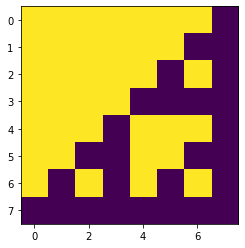

In [4]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,True,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
# num_episodes = 10000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_4={}
env2=copy.copy(env)
device = torch.device("cpu")

for man_init in ['Init','Nil','Exact','Learn']:
    print(man_init)
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_4[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[3, 7]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


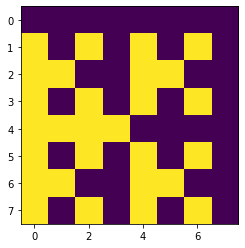

In [5]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_5={}

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
# num_episodes = 10000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env3=copy.copy(env)

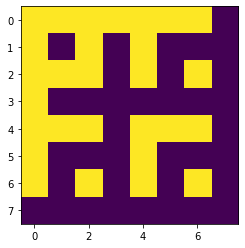

In [14]:
plt.imshow(env.maze)

In [22]:
r_d

dict_keys([0, 1, 2, 3])

In [11]:
# r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                              'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
# counter=counter+1

In [6]:


for man_init in ['Learn','Init','Nil','Exact']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
            print(man_init)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Exact


  0%|                                                                                 | 1/5000 [00:00<29:04,  2.86it/s]

epsilon 0.7987733333333333


  1%|▊                                                                               | 48/5000 [00:42<46:18,  1.78it/s]

x


  1%|▊                                                                             | 51/5000 [00:46<1:36:29,  1.17s/it]

epsilon 0.7365


  2%|█▋                                                                             | 103/5000 [01:23<24:43,  3.30it/s]

epsilon 0.723


  2%|█▉                                                                             | 125/5000 [01:38<25:12,  3.22it/s]

x


  3%|██▍                                                                            | 152/5000 [01:50<32:01,  2.52it/s]

epsilon 0.7095


  4%|███                                                                          | 201/5000 [02:11<1:02:52,  1.27it/s]

epsilon 0.696


  5%|███▉                                                                           | 251/5000 [02:27<25:25,  3.11it/s]

epsilon 0.6825


  6%|████▊                                                                          | 301/5000 [02:42<23:07,  3.39it/s]

epsilon 0.669


  7%|█████▌                                                                         | 351/5000 [02:56<28:41,  2.70it/s]

epsilon 0.6555
[37.47666666666667]
min mean 37.47666666666667
last mean 350    37.476667
dtype: float64


  8%|██████▎                                                                        | 401/5000 [03:08<30:24,  2.52it/s]

epsilon 0.642
[37.47666666666667, 29.79]
min mean 29.79
last mean 400    29.996667
dtype: float64


  8%|██████▍                                                                        | 410/5000 [03:10<18:49,  4.06it/s]

x


  9%|███████▏                                                                       | 452/5000 [03:19<16:15,  4.66it/s]

epsilon 0.6285000000000001
[37.47666666666667, 29.79, 25.41]
min mean 25.41
last mean 450    25.44
dtype: float64


 10%|███████▌                                                                       | 476/5000 [03:23<10:04,  7.48it/s]

x


 10%|███████▉                                                                       | 502/5000 [03:29<12:38,  5.93it/s]

epsilon 0.615
[37.47666666666667, 29.79, 25.41, 21.88]
min mean 21.88
last mean 500    21.88
dtype: float64


 11%|████████▍                                                                      | 534/5000 [03:36<30:45,  2.42it/s]

x


 11%|████████▋                                                                      | 551/5000 [03:38<15:59,  4.63it/s]

epsilon 0.6014999999999999
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667]
min mean 19.936666666666667
last mean 550    19.936667
dtype: float64


 12%|█████████▍                                                                     | 601/5000 [03:48<12:47,  5.73it/s]

epsilon 0.588
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666]
min mean 18.406666666666666
last mean 600    18.466667
dtype: float64


 13%|██████████▎                                                                    | 650/5000 [03:59<12:23,  5.85it/s]

epsilon 0.5745
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667]
min mean 17.64666666666667
last mean 650    17.646667
dtype: float64


 14%|███████████                                                                    | 702/5000 [04:08<11:37,  6.16it/s]

epsilon 0.5609999999999999
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665]
min mean 16.626666666666665
last mean 700    16.626667
dtype: float64


 15%|███████████▉                                                                   | 752/5000 [04:18<11:59,  5.90it/s]

epsilon 0.5475
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06]
min mean 16.06
last mean 750    16.153333
dtype: float64


 16%|████████████▏                                                                  | 775/5000 [04:21<10:56,  6.44it/s]

x


 16%|████████████▋                                                                  | 801/5000 [04:25<10:42,  6.54it/s]

x
epsilon 0.534
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333]
min mean 15.783333333333333
last mean 800    15.81
dtype: float64


 17%|█████████████▎                                                                 | 841/5000 [04:32<10:40,  6.50it/s]

x


 17%|█████████████▍                                                                 | 852/5000 [04:33<06:32, 10.58it/s]

epsilon 0.5205
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07]
min mean 15.07
last mean 850    15.07
dtype: float64


 18%|██████████████▎                                                                | 902/5000 [04:40<13:56,  4.90it/s]

epsilon 0.507
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667]
min mean 14.296666666666667
last mean 900    14.403333
dtype: float64


 19%|███████████████                                                                | 953/5000 [04:46<06:39, 10.14it/s]

epsilon 0.4935
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334]
min mean 13.173333333333334
last mean 950    13.186667
dtype: float64


 20%|███████████████▍                                                               | 978/5000 [04:50<07:36,  8.81it/s]

x


 20%|███████████████▌                                                              | 1001/5000 [04:52<06:30, 10.25it/s]

epsilon 0.48
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16]
min mean 12.16
last mean 1000    12.16
dtype: float64


 21%|████████████████▍                                                             | 1051/5000 [04:58<09:42,  6.78it/s]

epsilon 0.4665
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667]
min mean 11.056666666666667
last mean 1050    11.066667
dtype: float64


 22%|█████████████████                                                             | 1097/5000 [05:04<08:43,  7.46it/s]

x


 22%|█████████████████▏                                                            | 1101/5000 [05:04<07:23,  8.78it/s]

epsilon 0.45299999999999996
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45]
min mean 10.45
last mean 1100    10.45
dtype: float64


 23%|█████████████████▉                                                            | 1151/5000 [05:11<06:25,  9.99it/s]

epsilon 0.4395
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333]
min mean 9.973333333333333
last mean 1150    10.003333
dtype: float64


 24%|██████████████████▋                                                           | 1200/5000 [05:17<07:11,  8.80it/s]

epsilon 0.426
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333]
min mean 9.693333333333333
last mean 1200    9.713333
dtype: float64


 25%|███████████████████▍                                                          | 1246/5000 [05:23<08:19,  7.52it/s]

x


 25%|███████████████████▌                                                          | 1251/5000 [05:24<08:59,  6.95it/s]

epsilon 0.4125
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333]
min mean 9.393333333333333
last mean 1250    9.45
dtype: float64


 26%|████████████████████▎                                                         | 1301/5000 [05:29<06:30,  9.48it/s]

epsilon 0.39899999999999997
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26]
min mean 9.26
last mean 1300    9.326667
dtype: float64


 27%|█████████████████████                                                         | 1353/5000 [05:35<06:12,  9.79it/s]

epsilon 0.3855
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667]
min mean 9.126666666666667
last mean 1350    9.203333
dtype: float64


 28%|█████████████████████▊                                                        | 1402/5000 [05:41<05:47, 10.35it/s]

epsilon 0.372
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666]
min mean 8.916666666666666
last mean 1400    8.943333
dtype: float64


 29%|██████████████████████▋                                                       | 1451/5000 [05:46<06:25,  9.21it/s]

epsilon 0.3585
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667]
min mean 8.646666666666667
last mean 1450    8.696667
dtype: float64


 30%|███████████████████████▍                                                      | 1502/5000 [05:52<05:58,  9.76it/s]

epsilon 0.345
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334]
min mean 8.253333333333334
last mean 1500    8.253333
dtype: float64


 31%|████████████████████████▏                                                     | 1550/5000 [05:57<06:49,  8.42it/s]

epsilon 0.33149999999999996
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92]
min mean 7.92
last mean 1550    7.926667
dtype: float64


 32%|████████████████████████▉                                                     | 1601/5000 [06:02<05:05, 11.11it/s]

epsilon 0.31800000000000006
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74]
min mean 7.74
last mean 1600    7.756667
dtype: float64


 33%|█████████████████████████▊                                                    | 1653/5000 [06:07<05:19, 10.47it/s]

epsilon 0.3045
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665]
min mean 7.6066666666666665
last mean 1650    7.646667
dtype: float64


 34%|██████████████████████████▌                                                   | 1702/5000 [06:12<04:31, 12.17it/s]

epsilon 0.29100000000000004
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665]
min mean 7.3966666666666665
last mean 1700    7.4
dtype: float64


 35%|███████████████████████████▎                                                  | 1752/5000 [06:17<05:30,  9.82it/s]

epsilon 0.27749999999999997
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333]
min mean 7.123333333333333
last mean 1750    7.216667
dtype: float64


 36%|████████████████████████████                                                  | 1802/5000 [06:22<05:28,  9.75it/s]

epsilon 0.264
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666]
min mean 7.066666666666666
last mean 1800    7.08
dtype: float64


 37%|████████████████████████████▉                                                 | 1852/5000 [06:28<06:16,  8.37it/s]

epsilon 0.25049999999999994
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333]
min mean 6.943333333333333
last mean 1850    7.04
dtype: float64


 38%|█████████████████████████████▋                                                | 1902/5000 [06:33<06:57,  7.41it/s]

epsilon 0.237
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667]
min mean 6.886666666666667
last mean 1900    7.026667
dtype: float64


 39%|██████████████████████████████▍                                               | 1951/5000 [06:38<05:41,  8.93it/s]

epsilon 0.22350000000000003
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76]
min mean 6.76
last mean 1950    6.793333
dtype: float64


 40%|███████████████████████████████▏                                              | 2002/5000 [06:43<04:26, 11.23it/s]

epsilon 0.20999999999999996
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667]
min mean 6.636666666666667
last mean 2000    6.676667
dtype: float64


 41%|███████████████████████████████▉                                              | 2051/5000 [06:48<06:10,  7.96it/s]

epsilon 0.1965
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334]
min mean 6.593333333333334
last mean 2050    6.703333
dtype: float64


 42%|████████████████████████████████▊                                             | 2101/5000 [06:52<04:42, 10.25it/s]

epsilon 0.18300000000000005
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333]
min mean 6.573333333333333
last mean 2100    6.616667
dtype: float64


 43%|█████████████████████████████████▌                                            | 2153/5000 [06:57<03:49, 12.42it/s]

epsilon 0.16949999999999998
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666]
min mean 6.236666666666666
last mean 2150    6.236667
dtype: float64


 44%|██████████████████████████████████▎                                           | 2202/5000 [07:02<04:50,  9.62it/s]

epsilon 0.15599999999999992
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334]
min mean 6.093333333333334
last mean 2200    6.093333
dtype: float64


 45%|███████████████████████████████████▏                                          | 2253/5000 [07:06<03:49, 11.94it/s]

epsilon 0.14249999999999996
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91]
min mean 5.91
last mean 2250    5.923333
dtype: float64


 46%|███████████████████████████████████▉                                          | 2301/5000 [07:11<04:52,  9.22it/s]

epsilon 0.129
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335]
min mean 5.8533333333333335
last mean 2300    5.973333
dtype: float64


 47%|████████████████████████████████████▋                                         | 2352/5000 [07:16<03:59, 11.06it/s]

epsilon 0.11550000000000005
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85]
min mean 5.85
last mean 2350    5.853333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2401/5000 [07:21<03:40, 11.80it/s]

epsilon 0.10199999999999998
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333]
min mean 5.783333333333333
last mean 2400    5.786667
dtype: float64


 49%|██████████████████████████████████████▎                                       | 2452/5000 [07:25<04:04, 10.41it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73]
min mean 5.73
last mean 2450    5.826667
dtype: float64


 50%|███████████████████████████████████████                                       | 2501/5000 [07:31<04:23,  9.48it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73]
min mean 5.73
last mean 2500    5.806667
dtype: float64


 51%|███████████████████████████████████████▊                                      | 2553/5000 [07:36<04:18,  9.47it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334]
min mean 5.723333333333334
last mean 2550    5.84
dtype: float64


 52%|████████████████████████████████████████▌                                     | 2601/5000 [07:40<03:38, 10.97it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7]
min mean 5.7
last mean 2600    5.71
dtype: float64


 53%|█████████████████████████████████████████▎                                    | 2652/5000 [07:45<03:17, 11.88it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667]
min mean 5.536666666666667
last mean 2650    5.56
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [07:50<03:18, 11.58it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2700    5.586667
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2752/5000 [07:54<03:24, 11.00it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2750    5.62
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [07:58<03:04, 11.94it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2800    5.706667
dtype: float64


 57%|████████████████████████████████████████████▍                                 | 2852/5000 [08:02<03:26, 10.40it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2850    5.736667
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2904/5000 [08:07<02:24, 14.46it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2900    5.763333
dtype: float64


 59%|██████████████████████████████████████████████                                | 2953/5000 [08:10<02:58, 11.47it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 2950    5.756667
dtype: float64


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [08:14<02:31, 13.22it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 3000    5.676667
dtype: float64


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [08:18<02:35, 12.50it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 3050    5.713333
dtype: float64


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [08:23<02:36, 12.11it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667]
min mean 5.516666666666667
last mean 3100    5.61
dtype: float64


 63%|█████████████████████████████████████████████████▏                            | 3151/5000 [08:27<03:03, 10.05it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333]
min mean 5.373333333333333
last mean 3150    5.376667
dtype: float64


 64%|█████████████████████████████████████████████████▉                            | 3201/5000 [08:31<03:00,  9.99it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26]
min mean 5.26
last mean 3200    5.29
dtype: float64


 65%|██████████████████████████████████████████████████▋                           | 3253/5000 [08:35<02:11, 13.26it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22]
min mean 5.22
last mean 3250    5.22
dtype: float64


 66%|███████████████████████████████████████████████████▌                          | 3303/5000 [08:40<02:17, 12.32it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667]
min mean 5.136666666666667
last mean 3300    5.216667
dtype: floa

 67%|████████████████████████████████████████████████████▎                         | 3352/5000 [08:44<02:49,  9.71it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667]
min mean 5.136666666666667
last mean 3350    5

 68%|█████████████████████████████████████████████████████                         | 3403/5000 [08:48<02:04, 12.83it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333]
min mean 5.043333333333333


 69%|█████████████████████████████████████████████████████▊                        | 3449/5000 [08:52<02:12, 11.71it/s]

x
epsilon

 69%|█████████████████████████████████████████████████████▊                        | 3453/5000 [08:52<02:02, 12.60it/s]

 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04]
min mean 5.04
last mean 3450

 70%|██████████████████████████████████████████████████████▋                       | 3502/5000 [08:57<01:46, 14.03it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333]
mi

 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [09:01<02:25,  9.96it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 72%|████████████████████████████████████████████████████████▏                     | 3603/5000 [09:05<01:55, 12.08it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [09:09<01:55, 11.72it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 73%|█████████████████████████████████████████████████████████▎                    | 3674/5000 [09:11<01:41, 13.04it/s]

x


 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [09:14<02:23,  9.07it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 75%|██████████████████████████████████████████████████████████▌                   | 3753/5000 [09:18<01:34, 13.26it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [09:22<01:41, 11.79it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [09:27<01:56,  9.89it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [09:32<01:42, 10.72it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 79%|█████████████████████████████████████████████████████████████▋                | 3952/5000 [09:36<01:37, 10.72it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [09:41<01:37, 10.23it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 81%|███████████████████████████████████████████████████████████████▏              | 4052/5000 [09:46<01:32, 10.27it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [09:50<01:31,  9.85it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 83%|████████████████████████████████████████████████████████████████▊             | 4152/5000 [09:56<01:48,  7.80it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 84%|█████████████████████████████████████████████████████████████████▌            | 4202/5000 [10:02<01:42,  7.79it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [10:06<01:19,  9.43it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [10:12<01:14,  9.41it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 87%|███████████████████████████████████████████████████████████████████▉          | 4352/5000 [10:17<01:12,  8.95it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 88%|████████████████████████████████████████████████████████████████████▋         | 4401/5000 [10:22<01:04,  9.26it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 88%|████████████████████████████████████████████████████████████████████▊         | 4409/5000 [10:22<00:55, 10.60it/s]

x


 89%|█████████████████████████████████████████████████████████████████████▍        | 4452/5000 [10:27<00:53, 10.19it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [10:32<00:56,  8.80it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [10:37<00:50,  8.85it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [10:43<00:41,  9.54it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [10:48<00:43,  8.00it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [10:54<00:40,  7.38it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [11:01<00:32,  7.59it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [11:06<00:23,  8.61it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4852/5000 [11:12<00:18,  8.14it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [11:18<00:11,  8.54it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4952/5000 [11:24<00:05,  8.87it/s]

epsilon 0.1
[37.47666666666667, 29.79, 25.41, 21.88, 19.936666666666667, 18.406666666666666, 17.64666666666667, 16.626666666666665, 16.06, 15.783333333333333, 15.07, 14.296666666666667, 13.173333333333334, 12.16, 11.056666666666667, 10.45, 9.973333333333333, 9.693333333333333, 9.393333333333333, 9.26, 9.126666666666667, 8.916666666666666, 8.646666666666667, 8.253333333333334, 7.92, 7.74, 7.6066666666666665, 7.3966666666666665, 7.123333333333333, 7.066666666666666, 6.943333333333333, 6.886666666666667, 6.76, 6.636666666666667, 6.593333333333334, 6.573333333333333, 6.236666666666666, 6.093333333333334, 5.91, 5.8533333333333335, 5.85, 5.783333333333333, 5.73, 5.73, 5.723333333333334, 5.7, 5.536666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.516666666666667, 5.373333333333333, 5.26, 5.22, 5.136666666666667, 5.136666666666667, 5.043333333333333, 5.04, 5.003333333333333, 5.

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:30<00:00,  7.24it/s]


In [6]:
# r_dict_5.keys()

Init
Parameter containing:
tensor([[0.9648, 2.1257, 4.0456]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9647998213768005, 2.1257269382476807, 4.045607566833496]
Ratio M/L: 1.9031642747908382
[['E' 'S' 'S' 'W']
 ['E' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'W']]
[[list([(0, -8.499415397644043), (1, -6.807009220123291), (2, -6.633579730987549), (3, -8.135577201843262)])
  list([(0, -8.454676628112793), (1, -5.203658103942871), (2, -6.093018531799316), (3, -7.661380767822266)])
  list([(0, -7.657897472381592), (1, -3.6750833988189697), (2, -6.716472625732422), (3, -6.319240570068359)])
  list([(0, -8.361261367797852), (1, -5.879262924194336), (2, -7.7418928146362305), (3, -5.638240337371826)])]
 [list([(0, -7.6034159660339355), (1, -5.479511260986328), (2, -5.130243301391602), (3, -8.41996955871582)])
  list([(0, -6.3915581703186035), (1, -2.7227108478546143), (2, -3.407456636428833), (3, -6.974517822265625)])
  list([(0, -4.865233898162842), (1, -0.946971476078

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'S' 'S' 'S' 'W' 'W']
 ['E' 'E' 'S' 'S' 'S' 'S' 'W' 'W']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W']
 ['E' 'E' 'E' 'N' 'N' 'N' 'W' 'W']
 ['E' 'E' 'N' 'N' 'N' 'N' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'W' 'W']]
xxx


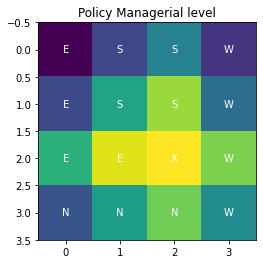

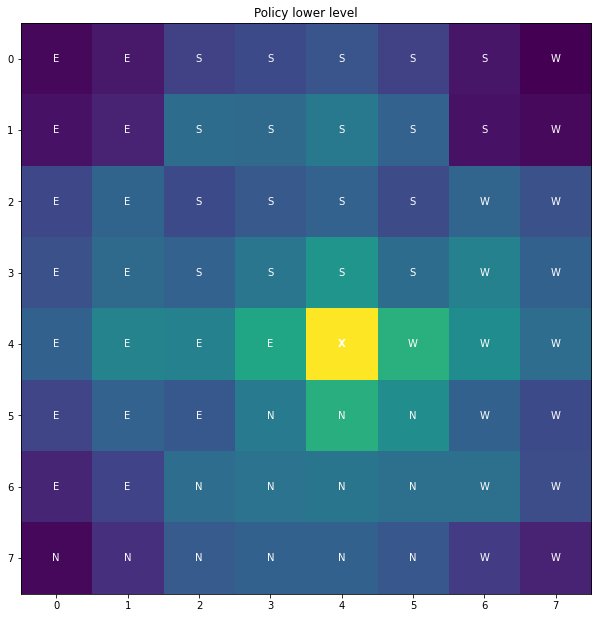

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['E' 'E' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -9.403844833374023), (1, -5.931112766265869), (2, -5.791472911834717), (3, -9.220308303833008)])
  list([(0, -9.888876914978027), (1, -5.3329081535339355), (2, -4.906367778778076), (3, -8.159085273742676)])
  list([(0, -7.714588165283203), (1, -2.878729820251465), (2, -4.960290908813477), (3, -6.313257694244385)])
  list([(0, -8.579315185546875), (1, -4.854579448699951), (2, -5.291306972503662), (3, -5.7667436599731445)])]
 [list([(0, -8.062910079956055), (1, -5.31582498550415), (2, -4.878198146820068), (3, -9.750165939331055)])
  list([(0, -7.541531085968018), (1, -3.8170900344848633), (2, -2.939016103744507), (3, -7.2574920654296875)])
  list([(0, -4.192312240600586), (1, -0.23791225254535675), (2, -3.5670523643493652), (3, -4.322237491607666)])
  list([(0, -6.4821414947509

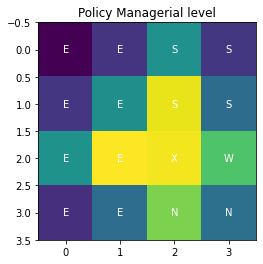

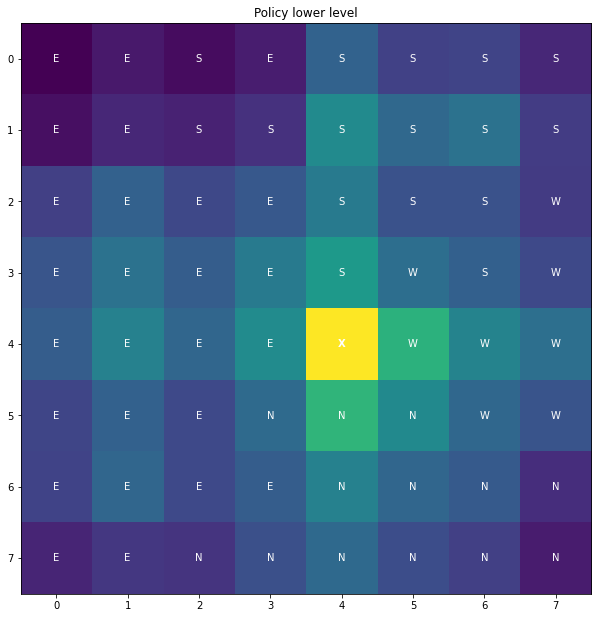

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['E' 'S' 'S' 'W']
 ['E' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -7.797351837158203), (1, -6.443969249725342), (2, -5.953190803527832), (3, -7.775373458862305)])
  list([(0, -7.717825889587402), (1, -4.940942287445068), (2, -5.525850296020508), (3, -6.513787746429443)])
  list([(0, -6.474470615386963), (1, -2.7075037956237793), (2, -6.210408687591553), (3, -5.9985880851745605)])
  list([(0, -8.19873046875), (1, -5.7011189460754395), (2, -6.745093822479248), (3, -5.688301086425781)])]
 [list([(0, -6.675721645355225), (1, -5.565045356750488), (2, -4.880284786224365), (3, -7.699755668640137)])
  list([(0, -5.84340763092041), (1, -3.0140111446380615), (2, -3.546482563018799), (3, -5.595067024230957)])
  list([(0, -3.7709743976593018), (1, -0.0722619891166687), (2, -5.111618518829346), (3, -4.3903985023498535)])
  list([(0, -6.794631958007812

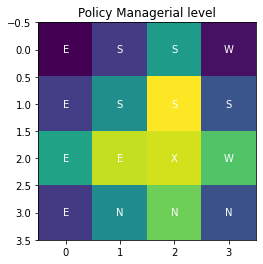

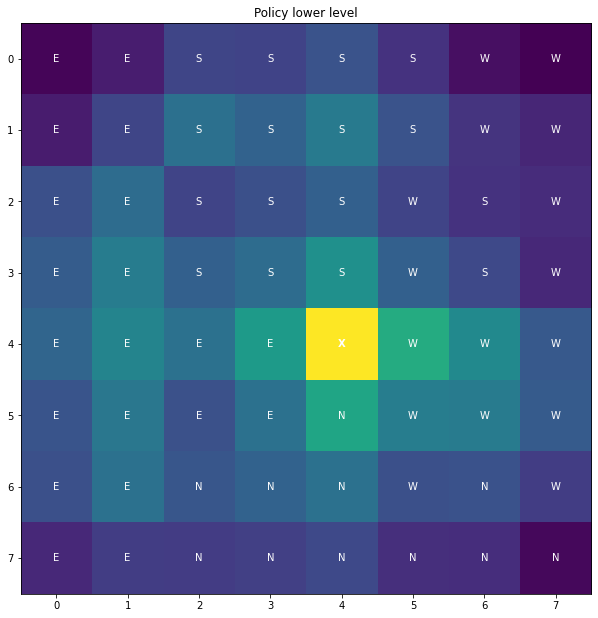

cccc
Learn
Parameter containing:
tensor([[0.0544, 0.3147, 0.7500]], requires_grad=True) Parameter containing:
tensor([0.2310], requires_grad=True)
[0.28547438979148865, 0.5456966161727905, 0.981028139591217]
Ratio M/L: 1.797753752756609
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -9.044986724853516), (1, -6.649275779724121), (2, -6.76649284362793), (3, -9.335532188415527)])
  list([(0, -8.880648612976074), (1, -5.5936737060546875), (2, -6.099724292755127), (3, -8.210138320922852)])
  list([(0, -7.10886812210083), (1, -3.9361400604248047), (2, -5.683435440063477), (3, -6.444870471954346)])
  list([(0, -7.285955429077148), (1, -5.142528057098389), (2, -6.2449049949646), (3, -6.280322551727295)])]
 [list([(0, -8.220491409301758), (1, -5.662303447723389), (2, -6.103447437286377), (3, -9.037554740905762)])
  list([(0, -7.303880214691162), (1, -3.4812583923339844), (2, -4.5229902267456055), (3, -6.954585075378418)])
  list([(0, -4.61354112625

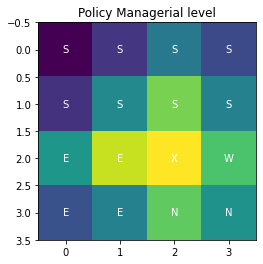

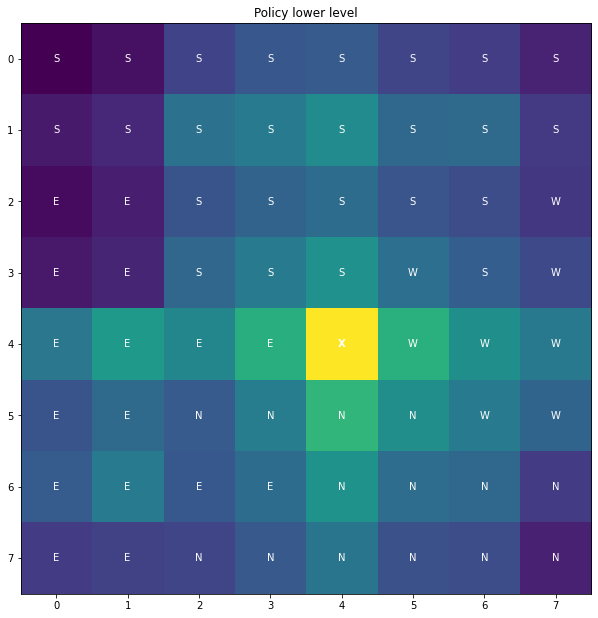

cccc
Init 4.33
Nil 4.32
Exact 4.32
Learn 4.4


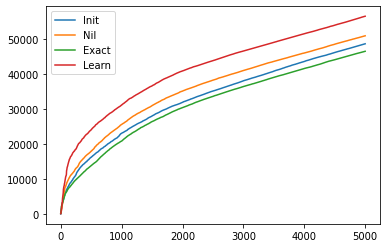

Init 4.33
Nil 4.32
Exact 4.32
Learn 4.4


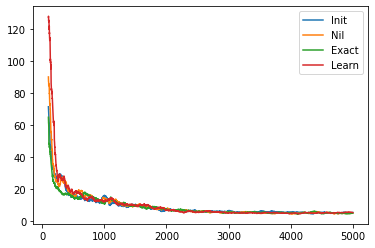

Init -16.29
Nil -17.04
Exact -17.37
Learn -17.94


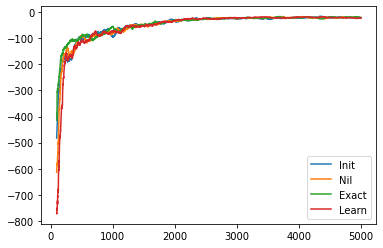

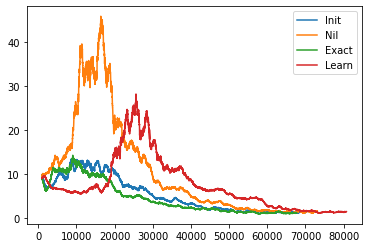

In [9]:

for x in range(4):
    labelp=r_dict_3[x]['man_init']
    nn=r_dict_3[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print_policy(nn, env1, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).expanding().sum().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    print(labelp,pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Init 5.65
Nil 5.94
Exact 6.03
Learn 5.55


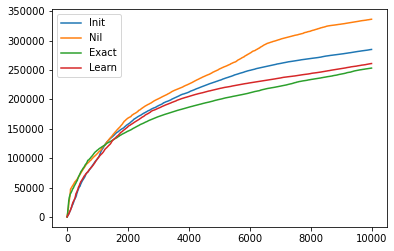

Init
Parameter containing:
tensor([[0.9062, 2.1365, 3.7616]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9062472581863403, 2.1365280151367188, 3.7615792751312256]
Ratio M/L: 1.760603768582233
[['S' 'E' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -23.557022094726562), (1, -21.01678466796875), (2, -21.095861434936523), (3, -23.110689163208008)])
  list([(0, -21.55855369567871), (1, -17.197750091552734), (2, -16.122718811035156), (3, -20.31641387939453)])
  list([(0, -17.483970642089844), (1, -8.534201622009277), (2, -15.21160888671875), (3, -16.41084098815918)])
  list([(0, -17.42459487915039), (1, -11.18025016784668), (2, -14.486395835876465), (3, -15.461143493652344)])]
 [list([(0, -20.44998550415039), (1, -16.749113082885742), (2, -16.472082138061523), (3, -21.69847297668457)])
  list([(0, -18.639142990112305), (1, -10.909305572509766), (2, -8.163250923156738), (3, -19.578636169433594)])
  list([(0, -11.573755264282227), (1, -0.39

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['MS' 'MS' 'MS' 'MS' 'MS' 'MS' 'MS' 'S']
 ['ME' 'MS' 'MS' 'MS' 'MS' 'MS' 'S' 'S']
 ['ME' 'ME' 'ME' 'ME' 'MS' 'S' 'MS' 'S']
 ['ME' 'ME' 'ME' 'ME' 'S' 'W' 'S' 'W']
 ['ME' 'ME' 'ME' 'E' 'X' 'MW' 'MW' 'S']
 ['ME' 'ME' 'E' 'N' 'MN' 'ME' 'S' 'W']
 ['ME' 'E' 'MN' 'E' 'MN' 'E' 'MW' 'W']
 ['E' 'E' 'E' 'E' 'E' 'N' 'W' 'W']]
xxx


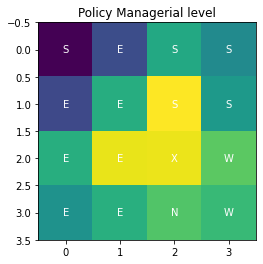

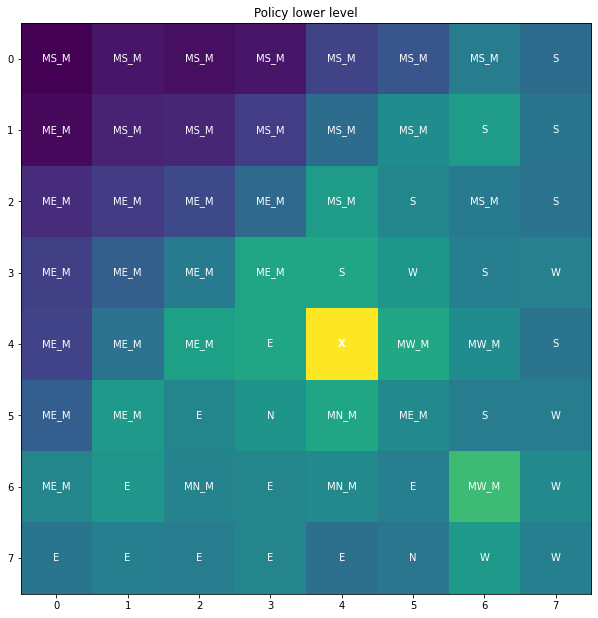

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'E' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -28.404085159301758), (1, -23.107696533203125), (2, -23.384536743164062), (3, -25.481136322021484)])
  list([(0, -26.697790145874023), (1, -20.681190490722656), (2, -19.448772430419922), (3, -23.048564910888672)])
  list([(0, -19.34283447265625), (1, -9.97388744354248), (2, -16.129085540771484), (3, -19.36153793334961)])
  list([(0, -20.971939086914062), (1, -10.600369453430176), (2, -15.485187530517578), (3, -18.616992950439453)])]
 [list([(0, -25.06635856628418), (1, -20.585451126098633), (2, -20.188405990600586), (3, -24.380603790283203)])
  list([(0, -24.473215103149414), (1, -14.052959442138672), (2, -12.571165084838867), (3, -23.311180114746094)])
  list([(0, -12.096131324768066), (1, -1.9089213609695435), (2, -10.914274215698242), (3, -15.080621719360352)])
  list([(0,

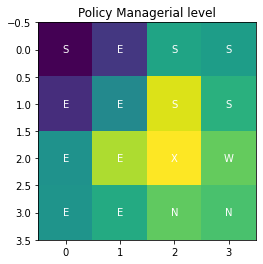

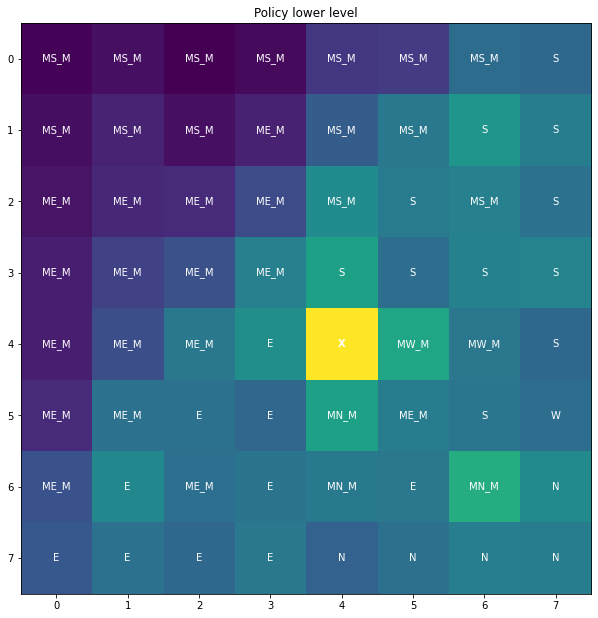

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -21.25432586669922), (1, -19.766796112060547), (2, -19.858718872070312), (3, -20.435436248779297)])
  list([(0, -18.88758087158203), (1, -14.827737808227539), (2, -16.469444274902344), (3, -17.52166175842285)])
  list([(0, -15.311844825744629), (1, -7.200702667236328), (2, -15.294483184814453), (3, -14.25135326385498)])
  list([(0, -15.13632583618164), (1, -9.726161003112793), (2, -13.342682838439941), (3, -13.243597984313965)])]
 [list([(0, -18.36219596862793), (1, -15.257635116577148), (2, -16.02970314025879), (3, -19.28087043762207)])
  list([(0, -16.1995849609375), (1, -6.443540096282959), (2, -11.131924629211426), (3, -17.515092849731445)])
  list([(0, -9.653976440429688), (1, -0.12176142632961273), (2, -10.820745468139648), (3, -10.600058555603027)])
  list([(0, -9.05

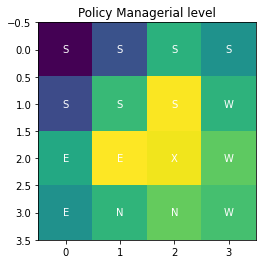

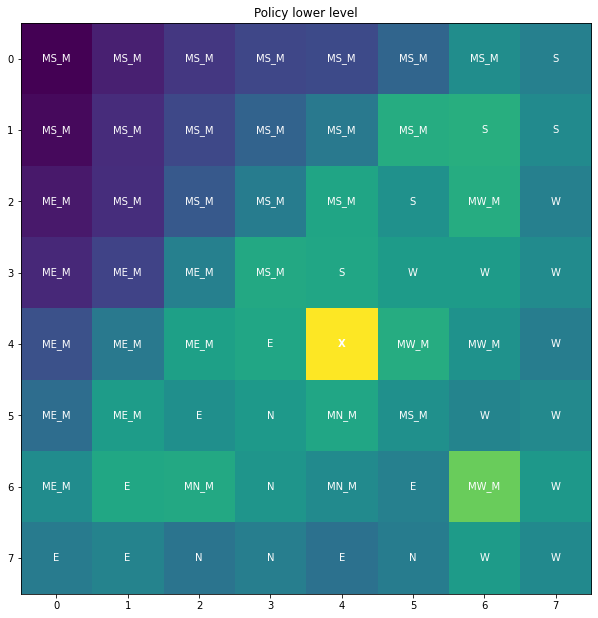

cccc
Learn
Parameter containing:
tensor([[0.1602, 0.7216, 0.6537]], requires_grad=True) Parameter containing:
tensor([0.2758], requires_grad=True)
[0.43600350618362427, 0.9974163770675659, 0.9294620752334595]
Ratio M/L: 0.9318696750960775
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -25.5833740234375), (1, -21.95413589477539), (2, -23.4462890625), (3, -25.96820831298828)])
  list([(0, -25.353023529052734), (1, -18.219593048095703), (2, -20.398258209228516), (3, -24.75153350830078)])
  list([(0, -21.169763565063477), (1, -9.462068557739258), (2, -16.752317428588867), (3, -21.627944946289062)])
  list([(0, -21.453466415405273), (1, -9.947846412658691), (2, -15.653836250305176), (3, -20.55551528930664)])]
 [list([(0, -23.497451782226562), (1, -18.847980499267578), (2, -21.236703872680664), (3, -25.77843475341797)])
  list([(0, -24.52507972717285), (1, -10.465392112731934), (2, -14.216465950012207), (3, -26.01088523864746)])
  list([(0, -15.

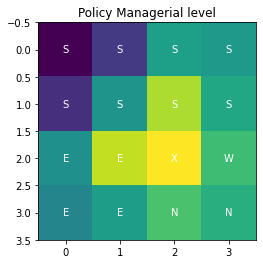

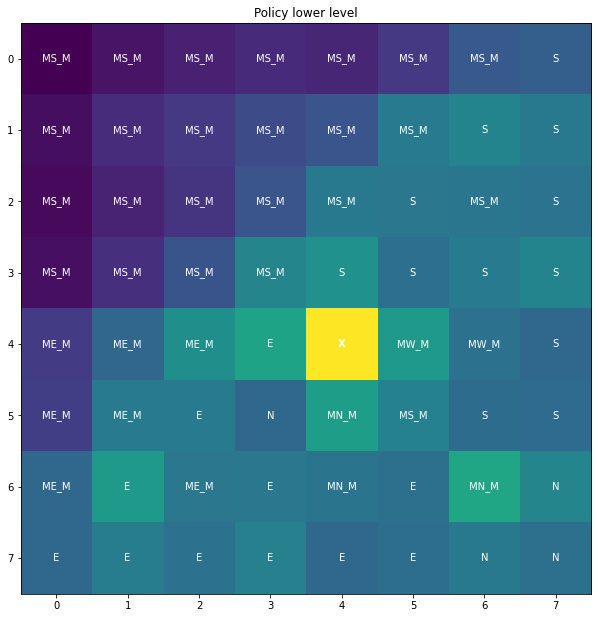

cccc
Init 5.92
Nil 7.05
Exact 6.36
Learn 7.11


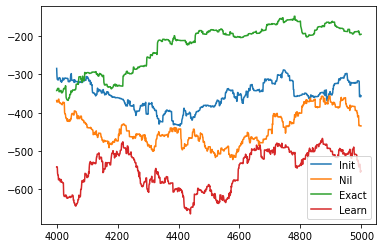

Init 5.92
Nil 7.05
Exact 6.36
Learn 7.11


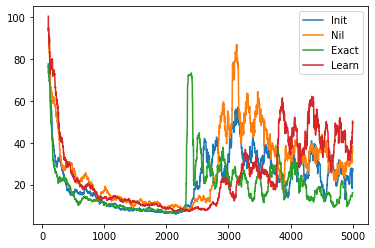

Init -64.25
Nil -77.22
Exact -68.73
Learn -75.9


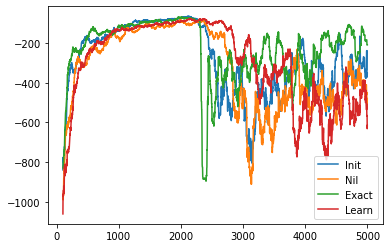

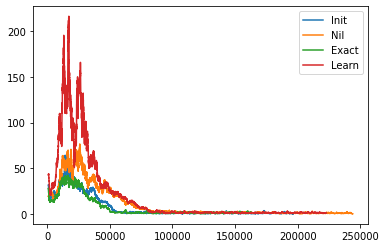

In [10]:
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    nn=r_dict_4[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print_policy(nn, env2, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['rewards']).rolling(300).mean().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    print(labelp,pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    pd.Series(r_dict_4[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Learn
Parameter containing:
tensor([[ 0.0246, -0.5367, -0.5386]], requires_grad=True) Parameter containing:
tensor([-0.4288], requires_grad=True)
[-0.40418022871017456, -0.9654987454414368, -0.9673731923103333]
Ratio M/L: 1.001941428590919
[['E' 'E' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -14.528958320617676), (1, -15.570013999938965), (2, -12.781950950622559), (3, -18.788074493408203)])
  list([(0, -13.444502830505371), (1, -11.693801879882812), (2, -10.879359245300293), (3, -15.300034523010254)])
  list([(0, -11.712739944458008), (1, -8.343402862548828), (2, -11.42644214630127), (3, -11.138306617736816)])
  list([(0, -12.341017723083496), (1, -8.708547592163086), (2, -11.762136459350586), (3, -11.003360748291016)])]
 [list([(0, -13.057412147521973), (1, -14.911208152770996), (2, -11.532218933105469), (3, -19.84562873840332)])
  list([(0, -10.793963432312012), (1, -11.115594863891602), (2, -8.652731895446777), (3, -15.173486709594727)])
  li

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'E' 'S' 'S' 'S' 'S']
 ['ME' 'E' 'MS' 'S' 'MS' 'S' 'MS' 'S']
 ['ME' 'ME' 'E' 'W' 'MS' 'MS' 'S' 'S']
 ['ME' 'E' 'ME' 'E' 'MS' 'S' 'MS' 'S']
 ['ME' 'ME' 'ME' 'ME' 'X' 'W' 'W' 'W']
 ['ME' 'E' 'ME' 'E' 'MN' 'N' 'MW' 'W']
 ['ME' 'ME' 'N' 'N' 'MN' 'MN' 'N' 'N']
 ['ME' 'E' 'MN' 'N' 'MN' 'N' 'MN' 'N']]
xxx


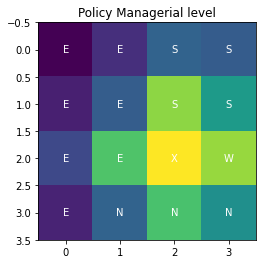

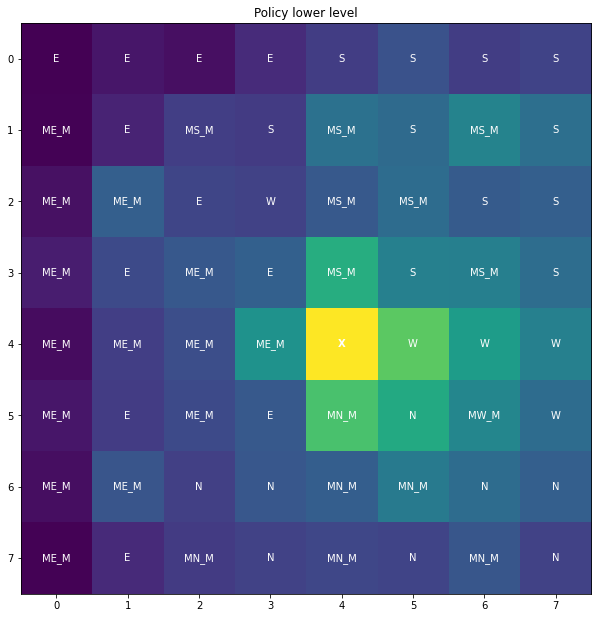

cccc
Init
Parameter containing:
tensor([[0.9640, 2.1884, 3.9343]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9640495777130127, 2.1883668899536133, 3.9342916011810303]
Ratio M/L: 1.7978208403913594
[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -14.117720603942871), (1, -14.216163635253906), (2, -14.058316230773926), (3, -16.096614837646484)])
  list([(0, -14.379616737365723), (1, -10.317756652832031), (2, -11.57725715637207), (3, -13.501530647277832)])
  list([(0, -12.176522254943848), (1, -7.078184127807617), (2, -12.572225570678711), (3, -10.441882133483887)])
  list([(0, -12.929608345031738), (1, -7.940596103668213), (2, -13.24741268157959), (3, -10.577969551086426)])]
 [list([(0, -13.319573402404785), (1, -13.011703491210938), (2, -11.904923439025879), (3, -17.054990768432617)])
  list([(0, -11.52777099609375), (1, -9.713189125061035), (2, -7.422380447387695), (3, -12.782378196716309)])
  list([(0, -9.734886169433594), 

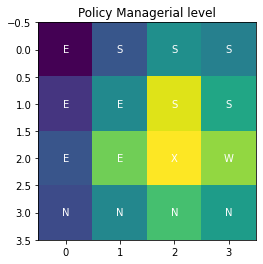

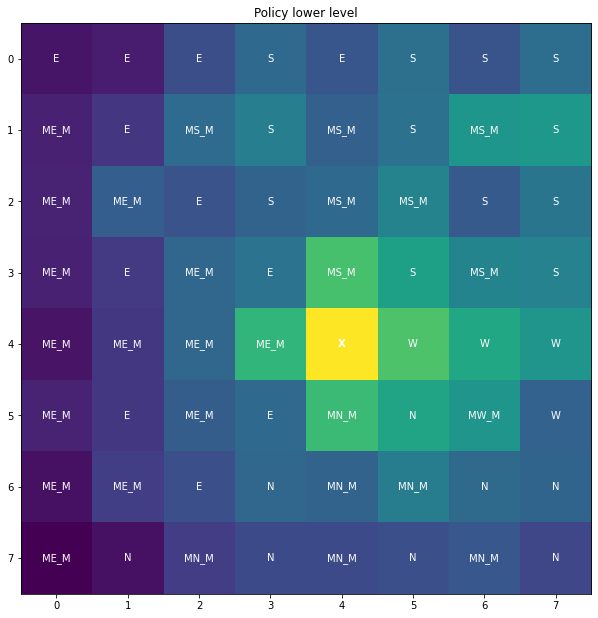

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -16.48212432861328), (1, -14.969989776611328), (2, -15.09903335571289), (3, -18.73087501525879)])
  list([(0, -15.726171493530273), (1, -11.929825782775879), (2, -13.203296661376953), (3, -15.838120460510254)])
  list([(0, -12.55954647064209), (1, -8.958776473999023), (2, -14.231254577636719), (3, -11.968782424926758)])
  list([(0, -13.038535118103027), (1, -8.813264846801758), (2, -13.993379592895508), (3, -11.721810340881348)])]
 [list([(0, -14.85107135772705), (1, -13.1997709274292), (2, -13.778489112854004), (3, -19.29414939880371)])
  list([(0, -12.6596040725708), (1, -9.522628784179688), (2, -11.183131217956543), (3, -14.758155822753906)])
  list([(0, -8.854910850524902), (1, -2.0351803302764893), (2, -10.829757690429688), (3, -8.392663955688477)])
  list([(0, -10.61609

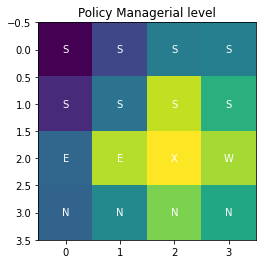

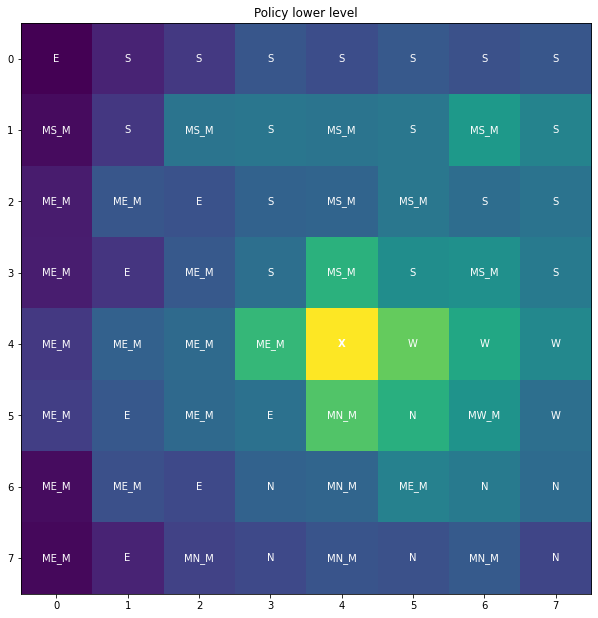

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['N' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -13.352760314941406), (1, -14.613469123840332), (2, -13.668195724487305), (3, -17.144065856933594)])
  list([(0, -13.453712463378906), (1, -10.815814018249512), (2, -12.576451301574707), (3, -14.782024383544922)])
  list([(0, -11.942087173461914), (1, -8.540956497192383), (2, -13.38354778289795), (3, -12.233796119689941)])
  list([(0, -12.793231964111328), (1, -9.120342254638672), (2, -13.999390602111816), (3, -12.862380027770996)])]
 [list([(0, -12.777986526489258), (1, -11.746960639953613), (2, -11.924511909484863), (3, -17.316116333007812)])
  list([(0, -10.879524230957031), (1, -7.714303016662598), (2, -10.16738224029541), (3, -13.148768424987793)])
  list([(0, -9.400735855102539), (1, -2.025118350982666), (2, -9.833642959594727), (3, -8.914396286010742)])
  list([(0, -

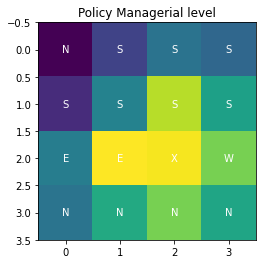

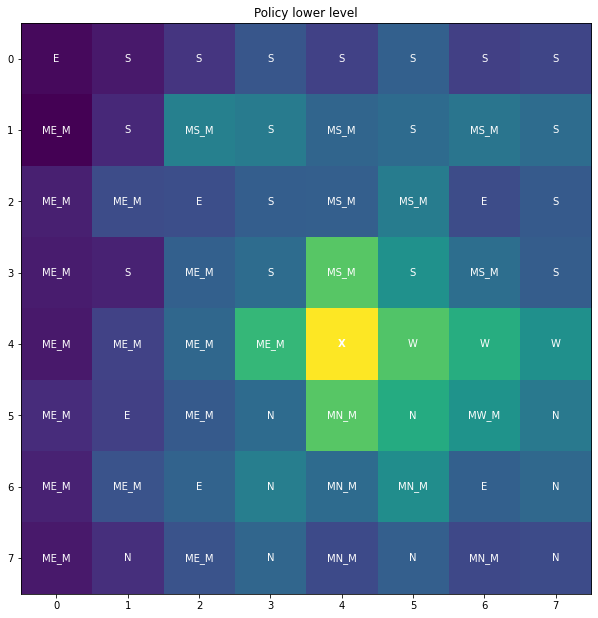

cccc
Learn 4.61
Init 4.33
Nil 4.48
Exact 4.43


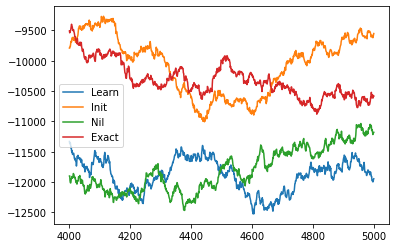

Learn 4.61
Init 4.33
Nil 4.48
Exact 4.43


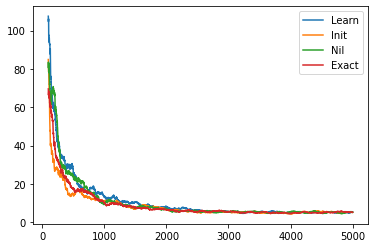

Learn -33.48
Init -28.86
Nil -32.49
Exact -28.68


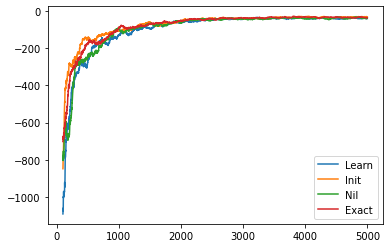

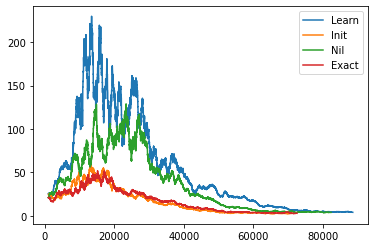

In [11]:
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    nn=r_dict_5[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print_policy(nn, env3, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    print(labelp,pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    pd.Series(r_dict_5[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

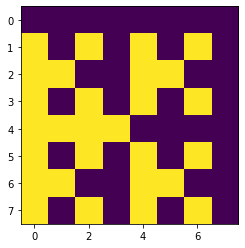

In [12]:
plt.imshow(env3.maze
          )

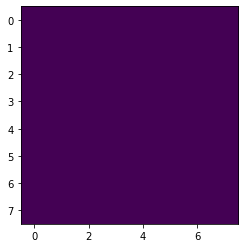

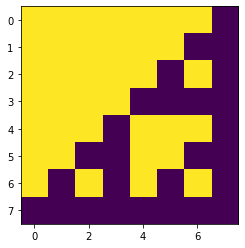

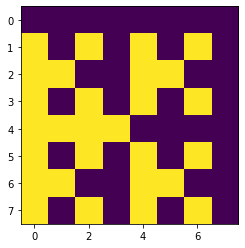

In [14]:
for e in [env1,env2,env3]:
    plt.imshow(e.maze)
    plt.show()

#

Init 22.200158096338033
Nil 22.88762447284077
Exact 19.986174420386465
Learn 25.51496598204514


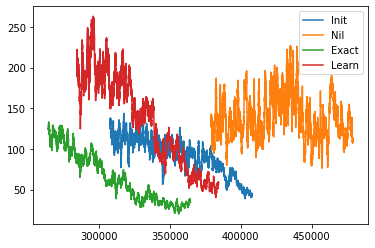

In [122]:
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().tail(100000).plot(label=labelp)
    print(labelp,pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().min())
plt.legend()

In [64]:
np.array([pd.Series(r_dict_3[x]['losses']) for x in range(4)])

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0           0.944539
1           4.000000
2         116.894913
3           0.962077
4           0.956444
             ...    
395262      1.541258
395263      4.000000
395264      8.323048
395265     36.082764
395266      7.426988
Length: 395267, dtype: float64,
       0           0.868928
1           0.853750
2           8.439255
3         121.108536
4           0.979999
             ...    
354883      1.000000
354884      0.233869
354885      5.187146
354886     46.029171
354887      6.011152
Length: 354888, dtype: float64,
       0           1.006482
1           1.007505
2           9.000000
3         117.600548
4           0.837997
             ...    
377156     13.437597
377157      3.808572
377158    231.068237
377159     29.945692
377160     15.245069
Length: 377161, dtype: float64,
       0           0.972997
1           4.000000
2         121.008476
3           0.829128
4           3.806385
             ...    
392085    179.027435
392086      1.000000
392087      8.5

In [23]:
pd.Series(losses).rolling(999).mean().tail(1).values[0]

96.32986692258063

In [24]:
import collections

In [25]:
a=collections.Counter([tuple(x) for x in ss])

<AxesSubplot:>

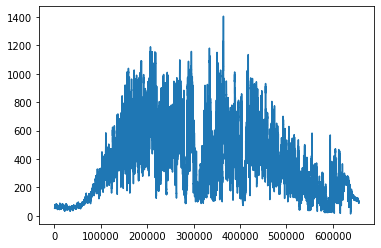

In [26]:
pd.Series(losses).rolling(500).mean().plot()

In [27]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [28]:
Q_policy.man_layer.bias

#

Parameter containing:
tensor([-0.4130], requires_grad=True)

In [29]:
Q_policy.man_layer.weight


Parameter containing:
tensor([[ 0.0246, -0.4764, -0.5448]], requires_grad=True)

In [30]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([-0.3883], grad_fn=<AddBackward0>)
tensor([-0.8894], grad_fn=<AddBackward0>)
tensor([-0.9577], grad_fn=<AddBackward0>)


In [31]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8885

In [32]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [33]:
PATH = "C:/Users/howar/AppData/Local/Programs/netron"
torch.save(Q_policy.state_dict(), os.path.join(PATH,"filename.pth"))

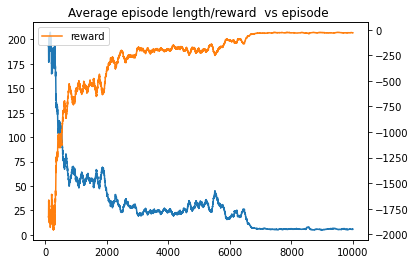

In [15]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [16]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8739

In [17]:
pd.Series(episode_durations).rolling(100).mean().min()

4.97

In [18]:
pd.Series(rewards).rolling(100).mean().max()

-23.61

In [19]:
pd.Series(rewards).rolling(100).mean().idxmax()

9525

In [20]:
a=pd.Series(rewards).rolling(100).mean()-pd.Series(rewards).rolling(100).mean().shift(-100)

In [89]:
a.tail(3000).idxmin()

7326

<AxesSubplot:>

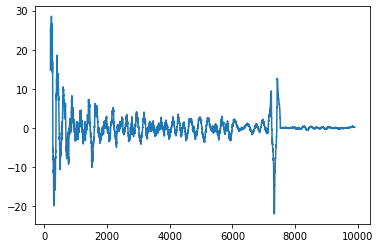

In [90]:
a.diff().rolling(100).mean().plot()

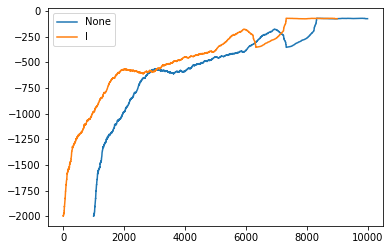

In [91]:
pd.Series(rewards).rolling(1000).mean().plot()
pd.Series(rewards).rolling(1000).mean().shift(-1000).plot(label='l')
plt.legend()

In [92]:
pd.Series(rewards).rolling(100).mean().max()

-53.25

In [93]:
pd.Series(rewards).rolling(50).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
9995   -73.68
9996   -73.98
9997   -73.98
9998   -74.94
9999   -75.36
Length: 10000, dtype: float64

In [127]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[ 0.0246, -0.5033, -0.5646]], requires_grad=True)